## Update: Tool-Independent Metrics

**Recent change:** The `compare-results` command now creates a synthetic tool called `all_tools_combined` which properly combines all unique alignments across tools using the existing coordinate tolerance and validation logic. This notebook now uses only this tool-independent row instead of averaging metrics across tools, which eliminates double-counting issues and provides accurate measurements of:

- How many unique spacers were detected (not how many times they were detected)
- True spurious match rates (unique non-planned alignments, not sum across tools)
- Proper recall and precision calculations

This approach leverages the existing functions in `compare_results.py` and `functions.py` for handling overlapping regions, coordinate tolerance, and alignment validation.

# Distance Metric Analysis: Hamming vs Edit Distance for CRISPR Spacer Detection

## Overview

This notebook quantifies how distance metric choice affects spurious match rates using simulated CRISPR spacer data with ground truth. We compare:
- **Hamming Distance** (≤N): Substitutions only, no indels allowed
- **Edit Distance** (≤N): Substitutions + indels allowed

We use the `compare-results` command which implements:
- **Coordinate tolerance matching** (5bp default) to handle slight boundary differences (e.g., placing a gap instead of a substitution in the terminal region of an alignment)
- **Verification**: All reported alignments (including those not in the ground truth) are verified by extracting the reference region and aligning to the reported spacer sequence
- **Classification into three categories**:
  - `positive_in_plan`: Matches ground truth (true positives)
  - `positive_not_in_plan`: Valid alignment NOT in ground truth (spurious/chance matches, or real matches when no GT exists)
  - `invalid_alignment`: **True False Positives** - failed verification (exceeds distance threshold)
- **Augmented metrics**: For simulated runs, adjusts metrics to include verified non-planned alignments as true positives

## Important Terminology:

**What are "False Positives" in this analysis?**
- **Invalid alignments** = True false positives (alignments that fail validation - the distance measured is larger than the accepeted thershold). Note, some tools don't really let us control setting a thershold, so some level of these is accepted.
- **Positives not in plan** ≠ False positives! These are:
  - Valid alignments that arise by chance (spurious matches)
  - Real biological matches (when there is no ground truth, e.g. real meta/genomes vs real spacers)
  - We mostly **ignore invalid alignments** in these plots and focus on spurious match rates. Main reason is that not all tools allow strict control over distance thresholds, so invalid alignments may be present due to tool's varying control over reporting setting - for example, with blastn, we can't hard-set a max edit/hamming distance, the closest we can do is set a min percent identity and min query (spacer) coverage, which allow a range of distances to be reported, and this range may exceed our desired threshold in order to capture all valid matches (for example, a 85% identity, over at least 80% of the spacer, will allow for 3 distance for a spacer of length 20 (20 * 0.15 ), but will allow more for a spcaer of length 30 (30 * 0.15 = 4.5) [[[note that the length also matters - the %id is out of the aligned region, hence the qcoverage setting being so high]]]). In this example, if we use the code here and in compare_results.py to validate the alignments at 3 distance, those blastn alignments with distance 4 or 5 will be marked as invalid alignments, but that doesn't mean blastn did something wrong.
- **"*_Augemented"** = performance metrics that include all verified non-planned alignments (within allowed distance) as true positives.


**Metrics:**
- **TP_planned**: Planned spacers correctly identified
- **GT_planned**: Simulated ground truth (where/how we inserted spacers)
- **All_TP**: TP_planned + verified non-planned
- **GT_augmented**: GT_planned + verified non-planned
- **Invalid alignments**: Alignments that failed verification (true FPs)

**Performance Metrics:**
- **Precision (planned)**: TP_planned / (TP_planned + all non-TP)
- **Recall (planned)**: TP_planned / GT_planned
- **Precision (augmented)**: All_TP / (All_TP + invalid_alignments)
- **Recall (augmented)**: All_TP / GT_augmented
- **Spurious Rate**: `positives_not_in_plan / all_true_positives × 100` - not useful! this is dependent on how many planned insertions we made, and we control that value.
- **Invalid Rate**: `invalid_alignments / (all_alignments) × 100`  - "True" false positive rate, **however**, in many tools we can't strictly control the reporting to be exactly within our desired metric and value - hence this rate doesn't really indicate a tool is "wrong" or "bad", just that we couldn't strictly control it at command exec time.  
- **Spurious Frequency**: Expected number of spurious matches, per a given search size: either for every n spacers searched in m contigs, or per n spacer-bp searched in m contig-bp (i.e. total length for each spacer searched, combined). This is a more useful metric, as it is independent of how many planned insertions we made). Apart from the simulations variables, this value is dependent on the distance metric used, the search space size, and thershold allowed.  

**Coordinate Tolerance Matching**: 
   - up to 5bp tolerance for alignments region -the slight boundary differences reduce the "double-counting" of e.g. a hit indel vs substitution placement on terminal ends.
   - Example: tool reports 5000-5036 (with 1 insertion) vs ground truth 5001-5036 (with 1 mismatch) → the hit with insertion is: verified (within the edit/hamming of up to 1 for the region in front of the spacer), and then counted as a 1 planned ground truth entry.   


**Reminder**: these analyses use a tool-independent aggreaget `all_tools_combined`, which merges unique alignments from all tools (allowing some coordinate tolerance for boundary differences).and validates each alignment. This avoids double-counting and provides accurate spurious match rates.
This might decrease the total count of hamming comapred to edit - as tradionally, hamming is expected to be of two strings of equal length. By allowing this small terminal ambiguity we kind of break that assumption. In the backend, in the validation step for these strings for hamming up to n, we pad the shorter sequence with `@` (a non IUPAC char, nothing aligns to it) (one time padding the aligned region from the right and one time from the left, then selecting the padded version with lowest hamming value), to make the lengths equal. In reality, a pure hamming distance based tool might still report these variations, if they are within the allowed threshold. For an edit/indel-allowing tool, non-equal lengths are a non-issue - and they may sometime "miss" (not report) the truncated version of the aligned region, if they can open a small gap that would allow a perfect match within the allowed edit distance. In this case, that reported alignment would be counted as a planned match if it overlaps the ground truth region within the coordinate tolerance, and the edit distance is within the allowed threshold. 
For example:
```bash
(benchy) [uneri@ln008 spacer_bench]$ grep "1c47e31b_spacer_10034" results/simulated/ns_100000_nc_10000/raw_outputs/*tsv |  grep "1c47e31b_contig_1828"
#                                                                            qaccver               saccver            nident length mismatch   qlen  gapopen qstart    qend   sstart   send    evalue      bitscore
results/simulated/ns_100000_nc_10000/raw_outputs/blastn_output.tsv:1c47e31b_spacer_10034        1c47e31b_contig_1828    34      34      0       35      0       1       34      5036    5003    5.27e-11       67.9

#                                                                                 query         ,target,              nident,alnlen,mismatch,qlen  ,gapopen, qstart,  qend,   tstart,  tend,  evalue,         bits
results/simulated/ns_100000_nc_10000/raw_outputs/mmseqs_output.tsv:1c47e31b_spacer_10034        1c47e31b_contig_1828    34      35      1       35      0       35      1       5002    5036    1.550E-10      60

#                                                                       pat_id          text_id               cost    strand    start   end       match_region                           cigar
results/simulated/ns_100000_nc_10000/raw_outputs/sassy.tsv:1c47e31b_spacer_10034        1c47e31b_contig_1828    1       -       5000    5036    AGTCTGGGCAGATGTGTCGACCGTTGTCTGACCGTG    34=1I1=


(benchy) [uneri@ln008 spacer_bench]$ grep "1c47e31b_spacer_10034" results/simulated/ns_100000_nc_10000/simulated_data/planned_ground_truth.tsv  | grep "1c47e31b_contig_1828"
# spacer_id              contig_id              start   end     strand  mismatches
1c47e31b_spacer_10034   1c47e31b_contig_1828    5001    5036    true    1
```


In [4]:
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

os.chdir('/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/')

import polars as pl
# import matplotlib.pyplot as plt
import subprocess
from pathlib import Path
import glob 

# Configuration
MAX_MISMATCHES_RANGE = [0, 1, 2, 3, 4, 5]

def run_compare_results(sim_dir, max_mismatches, distance_metric='hamming', verbose=False, logfile=None, skip_existing = True):
    """
    Run compare-results command for a simulation directory.
    
    Args:
        sim_dir: Path to simulation directory
        max_mismatches: Maximum allowed mismatches
        distance_metric: 'hamming' or 'edit'
        verbose: Whether to run in verbose mode (DEBUG logging to console)
        logfile: Optional path to logfile for DEBUG output (always DEBUG level, independent of --verbose)
        skip_existing (bool): if results already exist, should they be read from disk instead of recomputed...
        
    Returns:
        Path to performance_results_{distance_metric}_mm{max_mismatches}.tsv file
        
    Note:
        - Verbose flag enables DEBUG logging to console (shows operational details)
        - Logfile always captures DEBUG level regardless of verbose flag
        - With recent updates, operational print() statements converted to logger.debug()
          so clean output in notebooks without verbose, detailed logs in logfile
        - If results already exist, skips re-running and displays INFO log lines
    """
    # Performance results are saved with distance metric and threshold in filename
    perf_file = Path(sim_dir) / f'performance_results_{distance_metric}_mm{max_mismatches}.tsv'
    
    # Check if results already exist
    results_exist = perf_file.exists()
    logfile_exists = logfile and Path(logfile).exists()
    
    if skip_existing:
        if results_exist and (not logfile or logfile_exists):
            print(f"✓ Found existing results: {perf_file.name}")
            
            # Display INFO lines from logfile if available
            if logfile_exists:
                print("  Displaying INFO log entries:")
                with open(logfile, 'r') as f:
                    for line in f:
                        if ' - INFO - ' in line:
                            # Extract just the message part after INFO
                            parts = line.split(' - INFO - ', 1)
                            if len(parts) == 2:
                                print(f"    INFO: {parts[1].rstrip()}")
            
            return perf_file
    
    # Results don't exist or logfile missing - run the command
    cmd = [
        'pixi', 'run', 'spacer_bencher',
        'compare-results',
        '--input-dir', str(sim_dir),
        '-mm', str(max_mismatches),
        '--distance', distance_metric,
        '--threads', '8',
        "--skip-hyperfine",
        "--tools-results-out-file", str(Path(sim_dir) / f"tools_results_{distance_metric}_mm{max_mismatches}.tsv"),
    ]
    
    if verbose:
        cmd.insert(3, '--verbose')
    
    if logfile:
        cmd.extend(['--logfile', str(logfile)])
    
    print(f"Running: {' '.join(cmd)}")
    # Don't capture output so user can see important messages
    result = subprocess.run(cmd)
    
    if result.returncode != 0:
        print("Error running compare-results!")
        if logfile:
            print(f"Check logfile for details: {logfile}")
        return None
    
    if not perf_file.exists():
        print(f"Performance results not found: {perf_file}")
        return None
    
    return perf_file

def load_performance_results(sim_dir, distance_metric='hamming', max_mismatches=3):
    """Load performance results TSV file for specific metric and threshold."""
    perf_file = Path(sim_dir) / f'performance_results_{distance_metric}_mm{max_mismatches}.tsv'
    if not perf_file.exists():
        print(f"Performance results not found: {perf_file}")
        return None
    
    return pl.read_csv(str(perf_file), separator='\t')

def analyze_simulation_threshold_sweep(sim_dir, distance_metric='hamming', thresholds=None, verbose=False, logfile_dir=None, skip_existing = True):
    """
    Run compare-results for multiple thresholds and extract tool-independent metrics.
    
    Args:
        sim_dir: Path to simulation directory
        distance_metric: 'hamming' or 'edit'
        thresholds: List of thresholds to test (default: 0-5)
        verbose: Whether to show verbose output (DEBUG to console)
        logfile_dir: Optional directory for logfiles (always DEBUG level)
        skip_existing (bool): if results already exist, should they be read from disk instead of recomputed...

        
    Returns:
        DataFrame with tool-independent metrics for each threshold.
        Uses the 'all_tools_combined' synthetic tool created by compare-results
        which combines all unique alignments across tools.
    """
    if thresholds is None:
        thresholds = MAX_MISMATCHES_RANGE
    
    results = []
    
    for threshold in thresholds:
        print(f"Analyzing {distance_metric} distance with threshold ≤ {threshold}...")
        
        # Setup logfile if requested
        logfile = None
        if logfile_dir:
            Path(logfile_dir).mkdir(parents=True, exist_ok=True)
            logfile = Path(logfile_dir) / f"compare_{distance_metric}_mm{threshold}.log"
        
        # Run compare-results
        perf_file = run_compare_results(sim_dir, threshold, distance_metric, verbose=verbose, logfile=logfile,skip_existing=skip_existing)
        
        if perf_file is None or not perf_file.exists():
            print(f"Skipping threshold {threshold} - no results")
            continue
        
        # Load results
        perf_df = pl.read_csv(str(perf_file), separator='\t')
        
        # Filter for the tool-independent "all_tools_combined" row
        combined_row = perf_df.filter(pl.col('tool') == 'all_tools_combined')
        
        if combined_row.height == 0:
            print(f"Warning: 'all_tools_combined' not found in results for threshold {threshold}")
            continue
        
        # Extract row as dictionary with Python values
        row = combined_row.to_dicts()[0]
        
        # Calculate derived metrics
        all_tp = row['all_true_positives']
        invalid = row['invalid_alignments']
        positives_not_in_plan = row['positives_not_in_plan']
        recall_planned = row['recall_planned']
        
        spurious_rate = (positives_not_in_plan / all_tp * 100) if all_tp > 0 else 0
        invalid_rate = (invalid / (all_tp + invalid) * 100) if (all_tp + invalid) > 0 else 0
        identified_pct = recall_planned * 100 if recall_planned is not None else 0
        missed_pct = (1 - recall_planned) * 100 if recall_planned is not None else 100
        
        # Extract metrics directly from the all_tools_combined row
        results.append({
            'threshold': threshold,
            'recall_planned': recall_planned,
            'precision_augmented': row['precision_augmented'],
            'recall_augmented': row['recall_augmented'],
            'spurious_rate_pct': spurious_rate,
            'invalid_rate_pct': invalid_rate,
            'identified_pct': identified_pct,
            'missed_pct': missed_pct,
            # Raw counts from the combined tool
            'all_true_positives': all_tp,
            'planned_true_positives': row['planned_true_positives'],
            'positives_not_in_plan': positives_not_in_plan,
            'invalid_alignments': invalid,
            'false_negatives_planned': row['false_negatives_planned'],
            'ground_truth_planned': row['ground_truth_planned'],
            'ground_truth_augmented': row['ground_truth_augmented'],
        })
    
    return pl.DataFrame(results)


## Comparison Across Different Search Space Sizes

We'll run `compare-results` for each simulation with both hamming and edit distance metrics across different thresholds to see how:
1. Distance metric choice affects spurious match rates (non-planned valid alignments)
2. Search space size (num_spacers × num_contigs) impacts spurious match frequency
3. Invalid alignment rates (true false positives that fail validation)
4. Coordinate tolerance matching improves detection

**Important:** We use the `all_tools_combined` synthetic tool created by `compare-results`, which combines all unique alignments from all tools using the existing coordinate matching and validation logic. This gives us tool-independent metrics without double-counting.

In [2]:
# Find all simulation folders starting with 'ns_'
simulated_base_dir = "results/simulated"
simulation_dirs = glob.glob(os.path.join(simulated_base_dir, "ns_*"))

def format_num(n):
    if n >= 1000000:
        return f"{n//1000000}M"
    elif n < 1000:
        return f"{n}"
    else:
        return f"{n//1000}k"

# Filter to only include directories with actual simulation data
valid_sim_dirs = []
for sim_dir in simulation_dirs:
    sim_data_dir = Path(sim_dir) / "simulated_data"
    if sim_data_dir.exists():
        gt_file = sim_data_dir / "planned_ground_truth.tsv"
        # Include even if GT is empty (for baseline comparison)
        valid_sim_dirs.append(sim_dir)

sim_prefixes = [os.path.basename(p) for p in valid_sim_dirs]

SIMULATION_NAMES = {}
for prefix in sim_prefixes:
    parts = prefix.split('_')
    if len(parts) >= 4:
        try:
            n_spacers = int(parts[1])
            n_contigs = int(parts[3])
            SIMULATION_NAMES[prefix] = f"{format_num(n_spacers)} spacers, {format_num(n_contigs)} contigs"
        except ValueError:
            # Skip if can't parse numbers (e.g., real_baseline)
            SIMULATION_NAMES[prefix] = prefix

print(f"Found {len(SIMULATION_NAMES)} simulations:")
for prefix, desc in SIMULATION_NAMES.items():
    print(f"  {prefix}: {desc}")

Found 8 simulations:
  ns_100000_nc_10000: 100k spacers, 10k contigs
  ns_100000_nc_20000: 100k spacers, 20k contigs
  ns_100_nc_50000: 100 spacers, 50k contigs
  ns_3826979_nc_421431_real_baseline: 3M spacers, 421k contigs
  ns_500000_nc_100000: 500k spacers, 100k contigs
  ns_50000_nc_5000: 50k spacers, 5k contigs
  ns_500_nc_5000_HIGH_INSERTION_RATE: 500 spacers, 5k contigs
  ns_75000_nc_5000: 75k spacers, 5k contigs


Now testing the ones that had sassy + other tools (so can compare to a min edit exhustive tool results)

In [3]:
# Exclude only the semi-synthetic baseline (real spacers) - analyzed separately
semi_synthetic = SIMULATION_NAMES.pop("ns_3826979_nc_421431_real_baseline", None)
# Keep all other simulated datasets for search space analysis
large_simulated = SIMULATION_NAMES.pop("ns_500000_nc_100000", None)
# medium_simulated = SIMULATION_NAMES.pop("ns_100000_nc_20000", None)
high_insertion_rate = SIMULATION_NAMES.pop("ns_500_nc_5000_HIGH_INSERTION_RATE", None)
# now removing some place holders not actually ran:
SIMULATION_NAMES.pop("ns_100_nc_50000", None)

print(f"Analyzing {len(SIMULATION_NAMES)} simulations:")
for prefix in SIMULATION_NAMES:
    print(f"  - {prefix}")

Analyzing 4 simulations:
  - ns_100000_nc_10000
  - ns_100000_nc_20000
  - ns_50000_nc_5000
  - ns_75000_nc_5000


In [4]:
# Run analysis for each simulation with both distance metrics
comparison_results = []

for sim_prefix in SIMULATION_NAMES.keys():
    sim_dir = f"results/simulated/{sim_prefix}"
    description = SIMULATION_NAMES[sim_prefix]
    

    print(f"Processing: {sim_prefix}")
    print(f"Description: {description}")
    
    # Analyze with Hamming distance
    print("--- HAMMING DISTANCE ---")
    hamming_results = analyze_simulation_threshold_sweep(
        sim_dir, 
        distance_metric='hamming',
        thresholds=MAX_MISMATCHES_RANGE,
        verbose=False,
        logfile_dir= f"{sim_dir}/logs",
        skip_existing=False,

    )
    
    # Analyze with Edit distance
    print("--- EDIT DISTANCE ---")
    edit_results = analyze_simulation_threshold_sweep(
        sim_dir,
        distance_metric='edit',
        thresholds=MAX_MISMATCHES_RANGE,
        verbose=False,
        logfile_dir= f"{sim_dir}/logs",
        skip_existing=False,

    )
    
    comparison_results.append({
        'sim_prefix': sim_prefix,
        'description': description,
        'hamming_results': hamming_results,
        'edit_results': edit_results
    })
    
    print(f"✓ Completed {sim_prefix}")
    

print(f"Analysis complete for {len(comparison_results)} simulations")

Processing: ns_100000_nc_10000
Description: 100k spacers, 10k contigs
--- HAMMING DISTANCE ---
Analyzing hamming distance with threshold ≤ 0...
✓ Found existing results: performance_results_hamming_mm0.tsv
  Displaying INFO log entries:
    INFO: Logging DEBUG output to: results/simulated/ns_100000_nc_10000/logs/compare_hamming_mm0.log
    INFO: Comparing tool results in results/simulated/ns_100000_nc_10000
    INFO: Found 11 tool config files
    INFO: Successfully loaded 11 tool configurations
    INFO: qend < qstart detected, assuming tend and tstart are reversed
    INFO: Read 544252 total alignment results
    INFO: Loaded 299499 ground truth annotations
    INFO: 50393 ground truth annotations within max mismatches of 0
    INFO: Initial pldf shape: (41328, 7)
    INFO: Unique entries in minipldf: (32311, 1)
    INFO: After filtering nulls: (32311, 1)
    INFO: Actual number of sequences in file: 100000
    INFO: 
    INFO: Number of sequences in chunk: 100000
    INFO: Joining w

In [5]:
comparison_results

[{'sim_prefix': 'ns_100000_nc_10000',
  'description': '100k spacers, 10k contigs',
  'hamming_results': shape: (6, 15)
  ┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
  │ threshold ┆ recall_pl ┆ precision ┆ recall_au ┆ … ┆ invalid_a ┆ false_neg ┆ ground_tr ┆ ground_t │
  │ ---       ┆ anned     ┆ _augmente ┆ gmented   ┆   ┆ lignments ┆ atives_pl ┆ uth_plann ┆ ruth_aug │
  │ i64       ┆ ---       ┆ d         ┆ ---       ┆   ┆ ---       ┆ anned     ┆ ed        ┆ mented   │
  │           ┆ f64       ┆ ---       ┆ f64       ┆   ┆ i64       ┆ ---       ┆ ---       ┆ ---      │
  │           ┆           ┆ f64       ┆           ┆   ┆           ┆ i64       ┆ i64       ┆ i64      │
  ╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
  │ 0         ┆ 1.0       ┆ 0.549416  ┆ 1.0       ┆ … ┆ 41328     ┆ 0         ┆ 50393     ┆ 50393    │
  │ 1         ┆ 1.0       ┆ 0.857679  ┆ 1.0       ┆ … ┆ 

In [ ]:
def create_comparison_plots(comparison_results, output_dir="results/simulated/plots", no_summary=False):
    """
    Create comprehensive comparison plots using tool-independent metrics.
    
    Args:
        comparison_results: List of result dicts from threshold sweeps
        output_dir: Where to save plots
        
    Note: Uses the 'all_tools_combined' synthetic tool which represents all unique
          alignments across tools (proper handling of overlaps and coordinate tolerance).
          Spurious hits are normalized by search space size (spacer length × contig length).
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Plot individual simulation threshold curves
    for results in comparison_results:
        sim_prefix = results['sim_prefix']
        plots_dir = f"results/simulated/{sim_prefix}/plots"
        os.makedirs(plots_dir, exist_ok=True)
        sim_dir = f"results/simulated/{sim_prefix}"
        
        spacer_file = f"{sim_dir}/simulated_data/simulated_spacers.fa"
        contig_file = f"{sim_dir}/simulated_data/simulated_contigs.fa"
        
        import pyfastx
        spacers_fasta = pyfastx.Fasta(spacer_file)
        contigs_fasta = pyfastx.Fasta(contig_file)
        
        n_spacers = len(spacers_fasta)
        n_contigs = len(contigs_fasta)
        total_spacer_length = sum(len(seq) for seq in spacers_fasta)
        total_contig_length = sum(len(seq) for seq in contigs_fasta)
        
        # Calculate search spaces
        count_product = n_spacers * n_contigs
        search_space_bp2 = total_spacer_length * total_contig_length
        
        # Get tool-independent data from all_tools_combined
        hamming_df = results['hamming_results']
        edit_df = results['edit_results']
        
        if hamming_df.height == 0:
            print(f"No hamming data in {sim_prefix}, skipping...")
            continue
        
        # Get absolute counts
        hamming_absolute = [row['positives_not_in_plan'] for row in hamming_df.to_dicts()]
        edit_absolute = [row['positives_not_in_plan'] for row in edit_df.to_dicts()] if edit_df.height > 0 else []
        
        # Calculate spurious frequency per count product (normalized to 1M spacer-contig pairs)
        hamming_per_M_pairs = [(count / count_product) * 1e6 for count in hamming_absolute]
        edit_per_M_pairs = [(count / count_product) * 1e6 for count in edit_absolute] if edit_absolute else []
        
        # Calculate spurious frequency per search space (normalized to 1 Gbp²)
        hamming_per_Gbp2 = [(count / search_space_bp2) * 1e9 for count in hamming_absolute]
        edit_per_Gbp2 = [(count / search_space_bp2) * 1e9 for count in edit_absolute] if edit_absolute else []
        
        # Print summary table for threshold=3
        print(f"{sim_prefix} - Summary at Threshold=3:")
        h_idx = 3 if len(hamming_absolute) > 3 else -1
        e_idx = 3 if len(edit_absolute) > 3 else -1
        print(f"  Hamming: {hamming_absolute[h_idx]:,} spurious | {hamming_per_M_pairs[h_idx]:.2f} per M pairs | {hamming_per_Gbp2[h_idx]:.4f} per Gbp²")
        if edit_absolute:
            print(f"  Edit:    {edit_absolute[e_idx]:,} spurious | {edit_per_M_pairs[e_idx]:.2f} per M pairs | {edit_per_Gbp2[e_idx]:.4f} per Gbp²")
        
        # Create 3 consolidated plots (Hamming + Edit on each)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
        
        # Plot 1: Absolute spurious counts
        # Replace zeros with small value for log plotting, or use symlog
        hamming_absolute_plot = [max(val, 0.1) for val in hamming_absolute]
        edit_absolute_plot = [max(val, 0.1) for val in edit_absolute] if edit_absolute else []
        
        ax1.plot(hamming_df['threshold'], hamming_absolute_plot, 'o-', 
                linewidth=2.5, markersize=8, label='Hamming', color="#1f77b4")
        if edit_absolute_plot:
            ax1.plot(edit_df['threshold'], edit_absolute_plot, '^-', 
                    linewidth=2.5, markersize=8, label='Edit', color="#ff7f0e")
        ax1.set_xlabel('Threshold', fontweight='bold', fontsize=12)
        ax1.set_ylabel('# Spurious (count - total observed)', fontweight='bold', fontsize=12)
        ax1.set_title('Absolute Count', fontweight='bold', fontsize=14)
        ax1.set_yscale('log')
        ax1.set_ylim(bottom=0.1)  # Set minimum y value
        ax1.grid(True, alpha=0.3, which='both')
        ax1.legend(fontsize=11)
        
        # Add note about zero replacement
        ax1.text(0.02, 0.98, 'Note: Zero values shown as 0.1 for log scale', 
                transform=ax1.transAxes, fontsize=8, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
        
        # Plot 2: Normalized per spacer-contig pairs
        hamming_per_M_plot = [max(val, 0.001) for val in hamming_per_M_pairs]
        edit_per_M_plot = [max(val, 0.001) for val in edit_per_M_pairs] if edit_per_M_pairs else []
        
        ax2.plot(hamming_df['threshold'], hamming_per_M_plot, 'o-', 
                linewidth=2.5, markersize=8, label='Hamming', color="#1f77b4")
        if edit_per_M_plot:
            ax2.plot(edit_df['threshold'], edit_per_M_plot, '^-', 
                    linewidth=2.5, markersize=8, label='Edit', color="#ff7f0e")
        ax2.set_xlabel('Threshold', fontweight='bold', fontsize=12)
        ax2.set_ylabel('Spurious Frequency\n(per M spacer-contig pairs)', fontweight='bold', fontsize=12)
        ax2.set_title(f'Normalized by Count\n({n_spacers:,} × {n_contigs:,})', fontweight='bold', fontsize=14)
        ax2.set_yscale('log')
        ax2.set_ylim(bottom=0.001)
        ax2.grid(True, alpha=0.3, which='both')
        ax2.legend(fontsize=11)
        
        # Add note about zero replacement
        ax2.text(0.02, 0.98, 'Note: Zero values shown as 0.001 for log scale', 
                transform=ax2.transAxes, fontsize=8, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
        
        # Plot 3: Normalized per search space bp²
        hamming_per_Gbp2_plot = [max(val, 0.00001) for val in hamming_per_Gbp2]
        edit_per_Gbp2_plot = [max(val, 0.00001) for val in edit_per_Gbp2] if edit_per_Gbp2 else []
        
        ax3.plot(hamming_df['threshold'], hamming_per_Gbp2_plot, 'o-', 
                linewidth=2.5, markersize=8, label='Hamming', color="#1f77b4")
        if edit_per_Gbp2_plot:
            ax3.plot(edit_df['threshold'], edit_per_Gbp2_plot, '^-', 
                    linewidth=2.5, markersize=8, label='Edit', color="#ff7f0e")
        ax3.set_xlabel('Threshold', fontweight='bold', fontsize=12)
        ax3.set_ylabel('Spurious Frequency\n(per Gbp² search space)', fontweight='bold', fontsize=12)
        ax3.set_title(f'Normalized by Search Space\n({total_spacer_length/1e6:.1f} Mbp × {total_contig_length/1e6:.1f} Mbp)', fontweight='bold', fontsize=14)
        ax3.set_yscale('log')
        ax3.set_ylim(bottom=0.00001)
        ax3.grid(True, alpha=0.3, which='both')
        ax3.legend(fontsize=11)
        
        # Add note about zero replacement
        ax3.text(0.02, 0.98, 'Note: Zero values shown as 0.00001 for log scale', 
                transform=ax3.transAxes, fontsize=8, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
        
        plt.suptitle(f'{sim_prefix} - {results["description"]}', 
                    fontsize=16, fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(f'{plots_dir}/threshold_analysis_spurious.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    if no_summary:
        return
    # Summary table
    print("SUMMARY COMPARISON (Threshold = 3, Tool-Independent)")
    summary_data = []
    for results in comparison_results:
        hamming_df = results['hamming_results'].filter(pl.col('threshold') == 3)
        edit_df = results['edit_results'].filter(pl.col('threshold') == 3)
        
        if hamming_df.height > 0:
            h_row = hamming_df.to_dicts()[0]
            
            # Calculate search space for this simulation
            sim_prefix = results['sim_prefix']
            sim_dir = f"results/simulated/{sim_prefix}"
            spacer_file = f"{sim_dir}/simulated_data/simulated_spacers.fa"
            contig_file = f"{sim_dir}/simulated_data/simulated_contigs.fa"
            import pyfastx
            spacers_fasta = pyfastx.Fasta(spacer_file)
            contigs_fasta = pyfastx.Fasta(contig_file)
            n_spacers = len(spacers_fasta)
            n_contigs = len(contigs_fasta)
            count_product = n_spacers * n_contigs
            
            h_count = h_row['positives_not_in_plan']
            h_per_M = (h_count / count_product) * 1e6
            
            row_data = {
                'Simulation': results['sim_prefix'],
                'Description': results['description'],
                'H_Count': h_count,
                'H_per_M_pairs': f"{h_per_M:.2f}",
            }
            
            if edit_df.height > 0:
                e_row = edit_df.to_dicts()[0]
                e_count = e_row['positives_not_in_plan']
                e_per_M = (e_count / count_product) * 1e6
                row_data['E_Count'] = e_count
                row_data['E_per_M_pairs'] = f"{e_per_M:.2f}"
            
            summary_data.append(row_data)
    
    summary_df = pl.DataFrame(summary_data)
    print(summary_df)
    
    # Summary plot with error bars across all simulations
    print("across all simulations...")
    
    # Collect data for each threshold across all simulations
    hamming_data = {t: {'absolute': [], 'per_M_pairs': [], 'per_gbp2': []} for t in MAX_MISMATCHES_RANGE}
    edit_data = {t: {'absolute': [], 'per_M_pairs': [], 'per_gbp2': []} for t in MAX_MISMATCHES_RANGE}
    
    for results in comparison_results:
        hamming_df = results['hamming_results']
        edit_df = results['edit_results']
        
        sim_prefix = results['sim_prefix']
        sim_dir = f"results/simulated/{sim_prefix}"
        try:
            spacer_file = f"{sim_dir}/simulated_data/simulated_spacers.fa"
            contig_file = f"{sim_dir}/simulated_data/simulated_contigs.fa"
            import pyfastx
            spacers_fasta = pyfastx.Fasta(spacer_file)
            contigs_fasta = pyfastx.Fasta(contig_file)
            n_spacers = len(spacers_fasta)
            n_contigs = len(contigs_fasta)
            total_spacer_length = sum(len(seq) for seq in spacers_fasta)
            total_contig_length = sum(len(seq) for seq in contigs_fasta)
            
            count_product = n_spacers * n_contigs
            search_space_bp2 = total_spacer_length * total_contig_length
            
            for row in hamming_df.to_dicts():
                t = row['threshold']
                if t in hamming_data:
                    count = row['positives_not_in_plan']
                    hamming_data[t]['absolute'].append(count)
                    hamming_data[t]['per_M_pairs'].append((count / count_product) * 1e6)
                    hamming_data[t]['per_gbp2'].append((count / search_space_bp2) * 1e9)
            
            for row in edit_df.to_dicts():
                t = row['threshold']
                if t in edit_data:
                    count = row['positives_not_in_plan']
                    edit_data[t]['absolute'].append(count)
                    edit_data[t]['per_M_pairs'].append((count / count_product) * 1e6)
                    edit_data[t]['per_gbp2'].append((count / search_space_bp2) * 1e9)
        except Exception as e:
            print(f"Warning: Could not load sequence files for {sim_prefix}: {e}")
            continue
    
    # Calculate means and std for plotting
    thresholds = sorted(hamming_data.keys())
    
    h_abs_mean = [np.mean(hamming_data[t]['absolute']) if hamming_data[t]['absolute'] else 0 for t in thresholds]
    h_abs_std = [np.std(hamming_data[t]['absolute']) if hamming_data[t]['absolute'] else 0 for t in thresholds]
    h_M_mean = [np.mean(hamming_data[t]['per_M_pairs']) if hamming_data[t]['per_M_pairs'] else 0 for t in thresholds]
    h_M_std = [np.std(hamming_data[t]['per_M_pairs']) if hamming_data[t]['per_M_pairs'] else 0 for t in thresholds]
    h_gbp2_mean = [np.mean(hamming_data[t]['per_gbp2']) if hamming_data[t]['per_gbp2'] else 0 for t in thresholds]
    h_gbp2_std = [np.std(hamming_data[t]['per_gbp2']) if hamming_data[t]['per_gbp2'] else 0 for t in thresholds]
    
    e_abs_mean = [np.mean(edit_data[t]['absolute']) if edit_data[t]['absolute'] else 0 for t in thresholds]
    e_abs_std = [np.std(edit_data[t]['absolute']) if edit_data[t]['absolute'] else 0 for t in thresholds]
    e_M_mean = [np.mean(edit_data[t]['per_M_pairs']) if edit_data[t]['per_M_pairs'] else 0 for t in thresholds]
    e_M_std = [np.std(edit_data[t]['per_M_pairs']) if edit_data[t]['per_M_pairs'] else 0 for t in thresholds]
    e_gbp2_mean = [np.mean(edit_data[t]['per_gbp2']) if edit_data[t]['per_gbp2'] else 0 for t in thresholds]
    e_gbp2_std = [np.std(edit_data[t]['per_gbp2']) if edit_data[t]['per_gbp2'] else 0 for t in thresholds]
    
    # Replace zeros with small values for log plotting
    h_abs_mean_plot = [max(val, 0.1) for val in h_abs_mean]
    e_abs_mean_plot = [max(val, 0.1) for val in e_abs_mean]
    h_M_mean_plot = [max(val, 0.001) for val in h_M_mean]
    e_M_mean_plot = [max(val, 0.001) for val in e_M_mean]
    h_gbp2_mean_plot = [max(val, 0.00001) for val in h_gbp2_mean]
    e_gbp2_mean_plot = [max(val, 0.00001) for val in e_gbp2_mean]
    
    # Create 3 consolidated plots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot 1: Absolute counts
    ax1.errorbar(thresholds, h_abs_mean_plot, yerr=h_abs_std, 
                 fmt='o-', linewidth=2.5, markersize=8, label='Hamming', color="#1f77b4", capsize=5)
    ax1.errorbar(thresholds, e_abs_mean_plot, yerr=e_abs_std,
                 fmt='^-', linewidth=2.5, markersize=8, label='Edit', color="#ff7f0e", capsize=5)
    ax1.set_xlabel('Threshold', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Spurious Frequency (count)', fontweight='bold', fontsize=12)
    ax1.set_title('Absolute Count', fontweight='bold', fontsize=14)
    ax1.set_yscale('log')
    ax1.set_ylim(bottom=0.1)
    ax1.grid(True, alpha=0.3, which='both')
    ax1.legend(fontsize=11)
    ax1.text(0.02, 0.98, 'Note: Zero values shown as 0.1', 
            transform=ax1.transAxes, fontsize=8, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    # Plot 2: Per M pairs
    ax2.errorbar(thresholds, h_M_mean_plot, yerr=h_M_std,
                 fmt='o-', linewidth=2.5, markersize=8, label='Hamming', color="#1f77b4", capsize=5)
    ax2.errorbar(thresholds, e_M_mean_plot, yerr=e_M_std,
                 fmt='^-', linewidth=2.5, markersize=8, label='Edit', color="#ff7f0e", capsize=5)
    ax2.set_xlabel('Threshold', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Spurious Frequency\n(per M spacer-contig pairs)', fontweight='bold', fontsize=12)
    ax2.set_title('Normalized by Count', fontweight='bold', fontsize=14)
    ax2.set_yscale('log')
    ax2.set_ylim(bottom=0.001)
    ax2.grid(True, alpha=0.3, which='both')
    ax2.legend(fontsize=11)
    ax2.text(0.02, 0.98, 'Note: Zero values shown as 0.001', 
            transform=ax2.transAxes, fontsize=8, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    # Plot 3: Per Gbp²
    ax3.errorbar(thresholds, h_gbp2_mean_plot, yerr=h_gbp2_std,
                 fmt='o-', linewidth=2.5, markersize=8, label='Hamming', color="#1f77b4", capsize=5)
    ax3.errorbar(thresholds, e_gbp2_mean_plot, yerr=e_gbp2_std,
                 fmt='^-', linewidth=2.5, markersize=8, label='Edit', color="#ff7f0e", capsize=5)
    ax3.set_xlabel('Threshold', fontweight='bold', fontsize=12)
    ax3.set_ylabel('Spurious Frequency\n(per Gbp² search space)', fontweight='bold', fontsize=12)
    ax3.set_title('Normalized by Search Space', fontweight='bold', fontsize=14)
    ax3.set_yscale('log')
    ax3.set_ylim(bottom=0.00001)
    ax3.grid(True, alpha=0.3, which='both')
    ax3.legend(fontsize=11)
    ax3.text(0.02, 0.98, 'Note: Zero values shown as 0.00001', 
            transform=ax3.transAxes, fontsize=8, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.suptitle(f'Mean ± SD Across {len(comparison_results)} Simulations', 
                fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'{output_dir}/summary_with_error_bars_spurious.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return summary_df


Next the actual comparison plots (tool-independent, using the "all_tools_combined" to derive metrics)

ns_100000_nc_10000 - Summary at Threshold=3:
  Hamming: 97 spurious | 0.10 per M pairs | 0.0000 per Gbp²
  Edit:    1,824 spurious | 1.82 per M pairs | 0.0007 per Gbp²


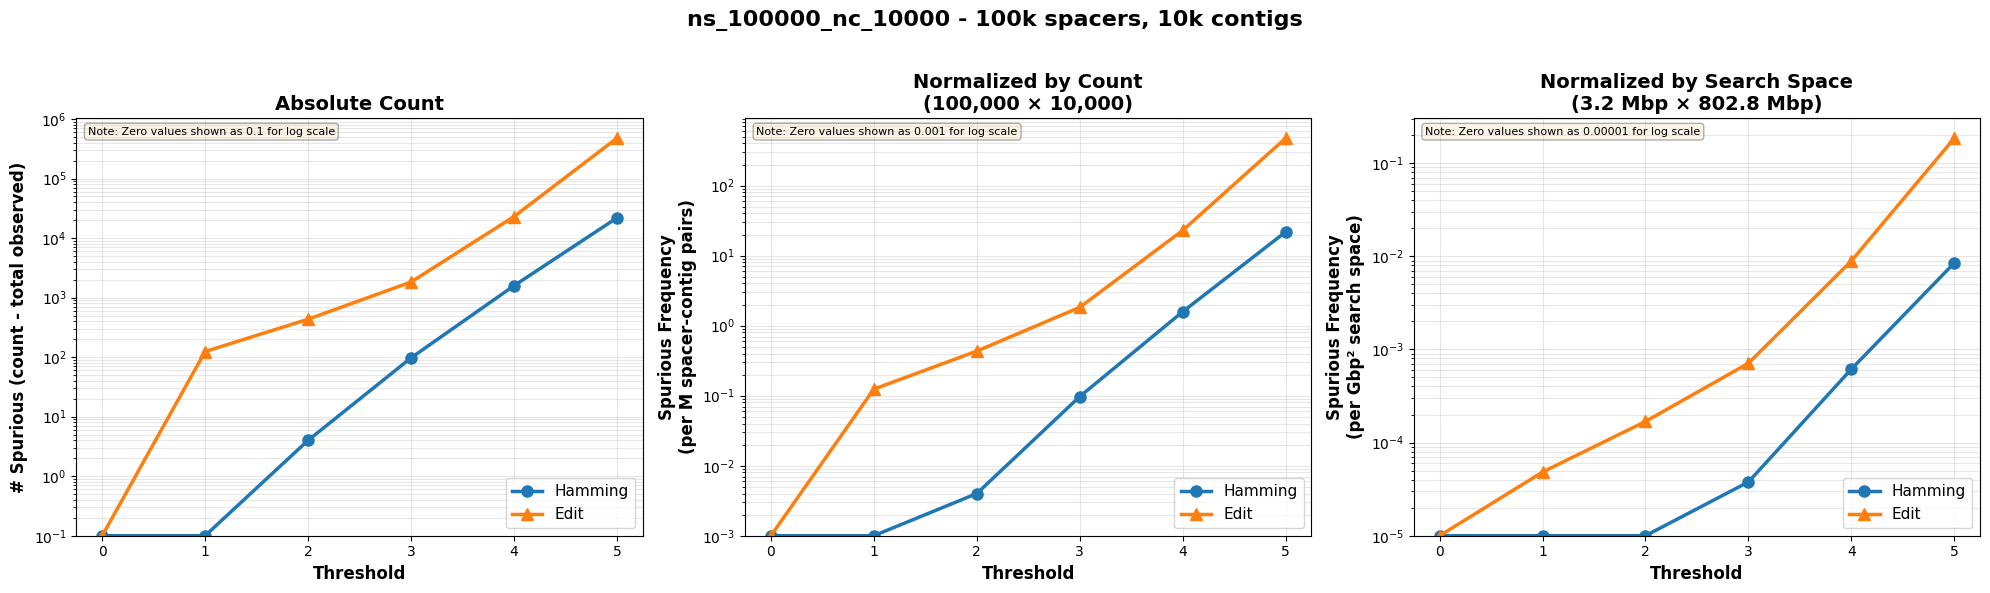

ns_100000_nc_20000 - Summary at Threshold=3:
  Hamming: 164 spurious | 0.08 per M pairs | 0.0000 per Gbp²
  Edit:    1,348 spurious | 0.67 per M pairs | 0.0003 per Gbp²


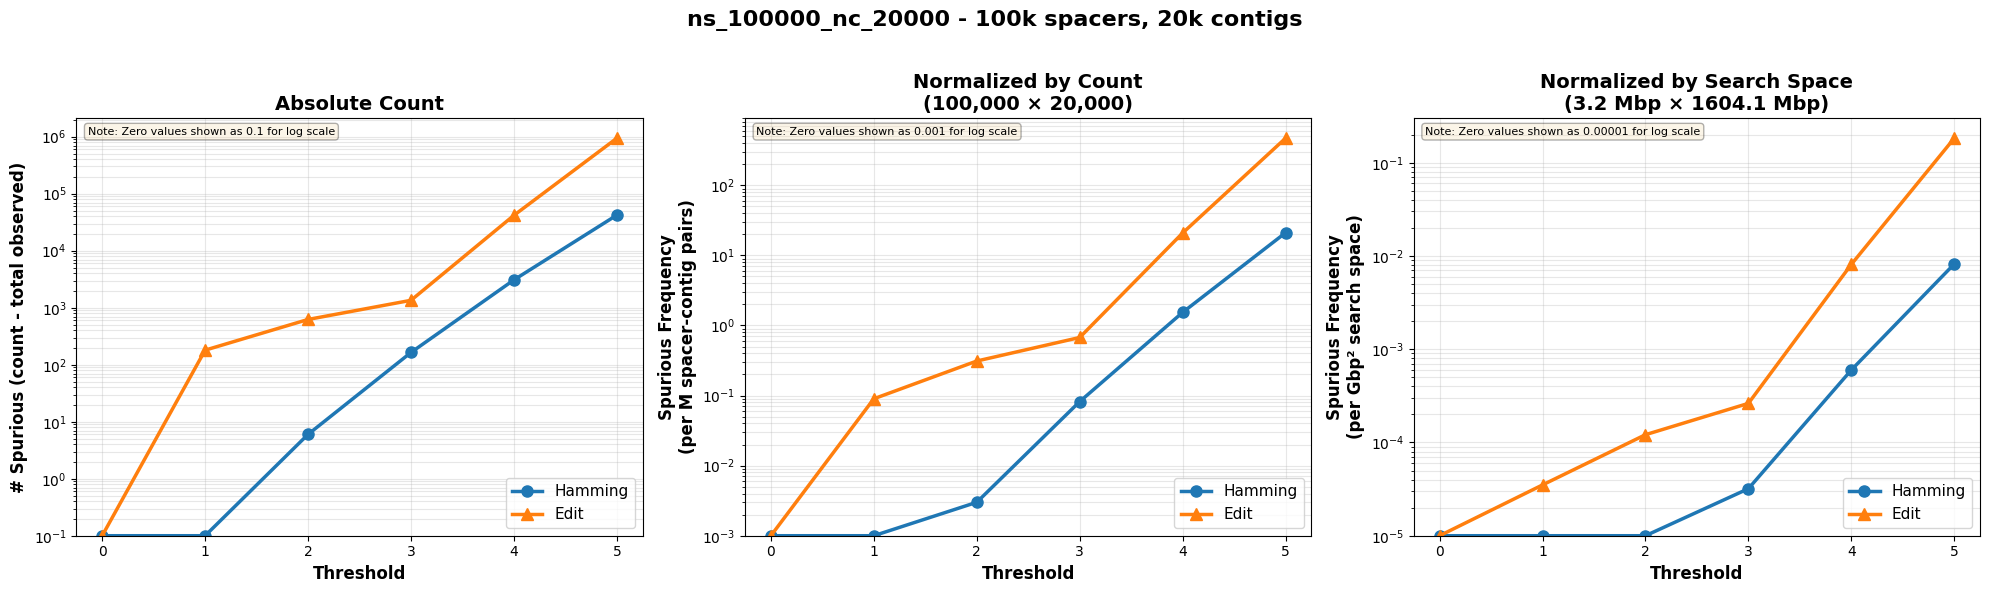

ns_50000_nc_5000 - Summary at Threshold=3:
  Hamming: 23 spurious | 0.09 per M pairs | 0.0000 per Gbp²
  Edit:    695 spurious | 2.78 per M pairs | 0.0011 per Gbp²


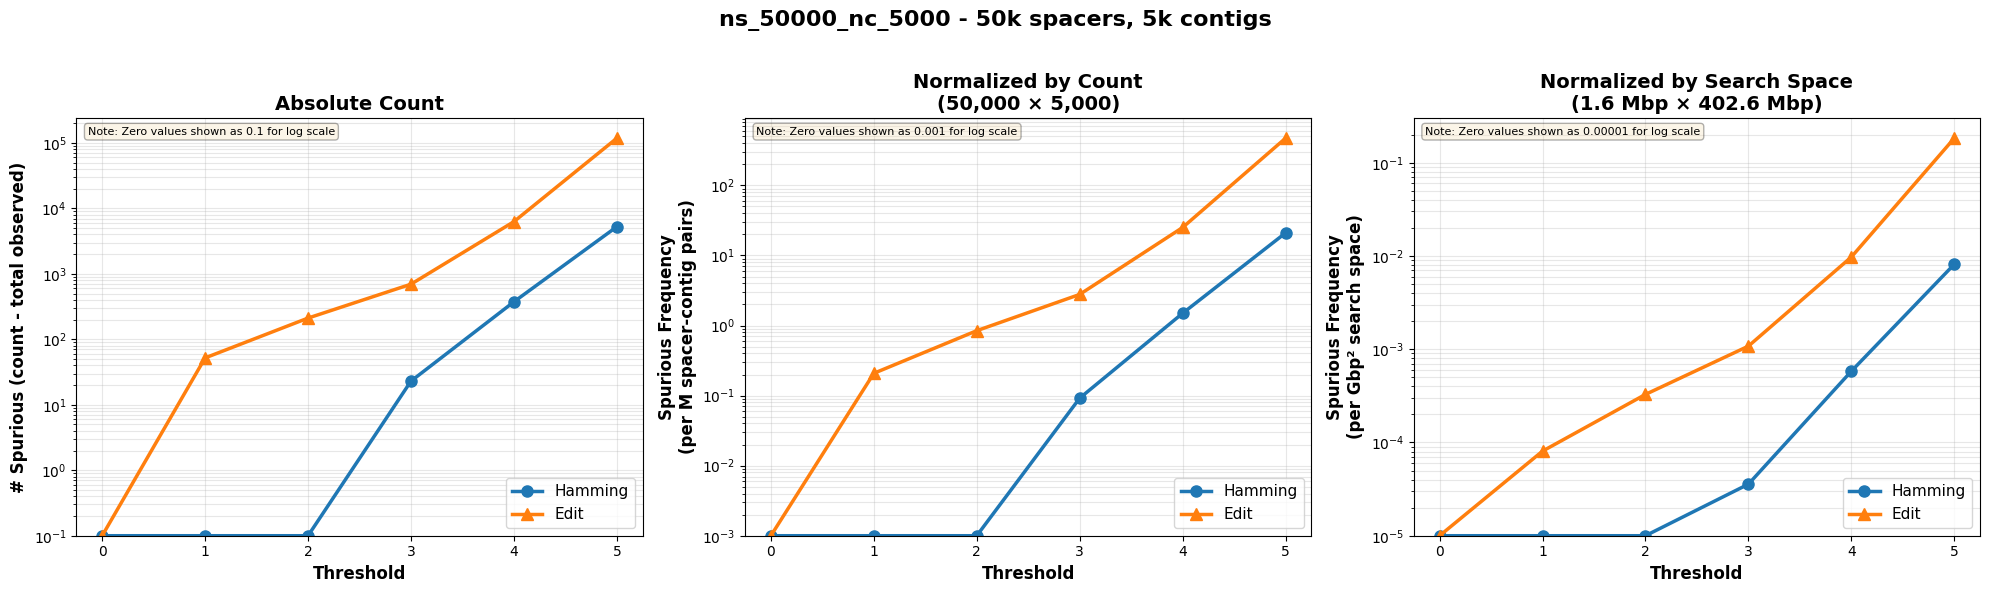

ns_75000_nc_5000 - Summary at Threshold=3:
  Hamming: 36 spurious | 0.10 per M pairs | 0.0000 per Gbp²
  Edit:    1,058 spurious | 2.82 per M pairs | 0.0011 per Gbp²


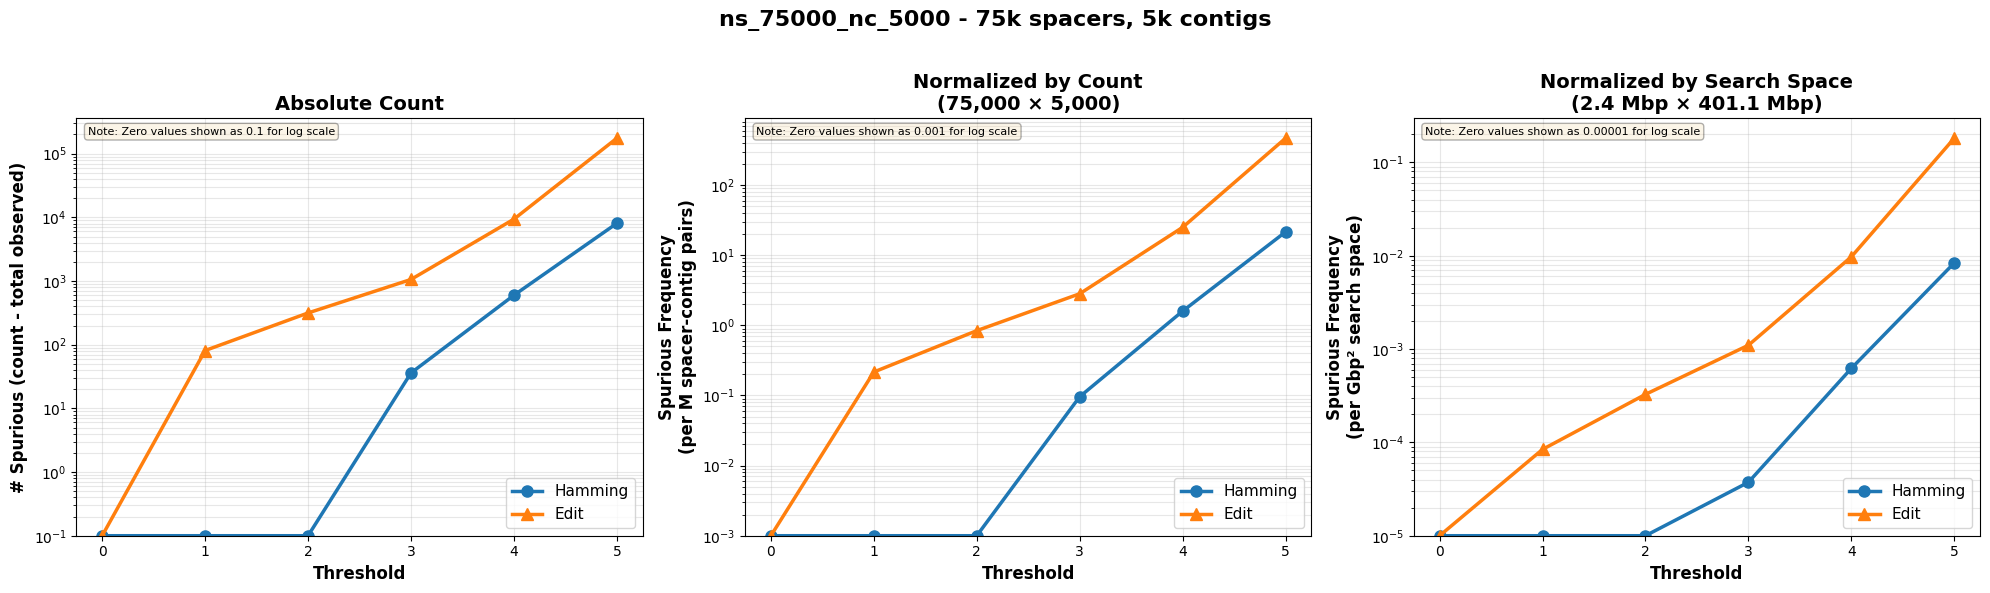

SUMMARY COMPARISON (Threshold = 3, Tool-Independent)
shape: (4, 6)
┌────────────────────┬─────────────────────────┬─────────┬───────────────┬─────────┬───────────────┐
│ Simulation         ┆ Description             ┆ H_Count ┆ H_per_M_pairs ┆ E_Count ┆ E_per_M_pairs │
│ ---                ┆ ---                     ┆ ---     ┆ ---           ┆ ---     ┆ ---           │
│ str                ┆ str                     ┆ i64     ┆ str           ┆ i64     ┆ str           │
╞════════════════════╪═════════════════════════╪═════════╪═══════════════╪═════════╪═══════════════╡
│ ns_100000_nc_10000 ┆ 100k spacers, 10k       ┆ 97      ┆ 0.10          ┆ 1824    ┆ 1.82          │
│                    ┆ contigs                 ┆         ┆               ┆         ┆               │
│ ns_100000_nc_20000 ┆ 100k spacers, 20k       ┆ 164     ┆ 0.08          ┆ 1348    ┆ 0.67          │
│                    ┆ contigs                 ┆         ┆               ┆         ┆               │
│ ns_50000_nc_5000   ┆ 5

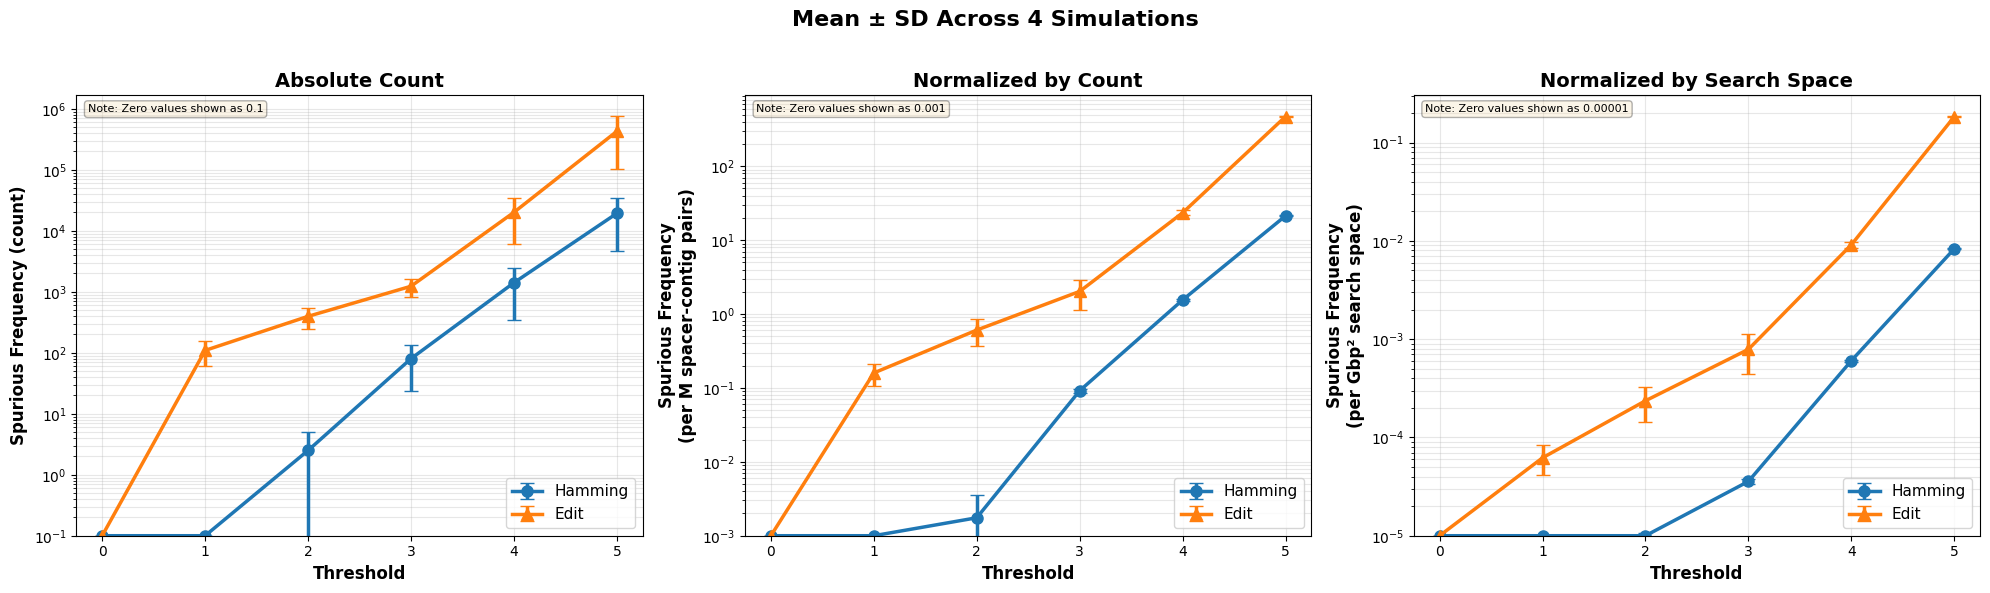

In [7]:
summary_df = create_comparison_plots(comparison_results)

## Search Space Effect on Spurious Match Rates

Before analyzing the semi-synthetic dataset, we examine how search space size affects spurious match rates. This helps us understand whether spurious matches scale with:

1. **Count-based search space**: Number of spacers × Number of contigs
2. **Length-based search space**: Total spacer sequence length × Total contig sequence length

We analyze:
- **Spurious rate percentage**: Proportion of valid alignments that are spurious
- **Absolute spurious count**: Total number of spurious matches found
- **Correlations**: How strongly each metric correlates with search space size

This analysis will help us extrapolate expected spurious rates for the semi-synthetic dataset based on its much larger search space (~3.8M spacers × 421K contigs).

Search Space Analysis (Threshold = 3):
Basic metrics:
shape: (4, 6)
┌───────────────────┬───────────┬───────────┬───────────────┬───────────────────┬──────────────────┐
│ sim_prefix        ┆ n_spacers ┆ n_contigs ┆ count_product ┆ total_spacer_leng ┆ total_contig_len │
│ ---               ┆ ---       ┆ ---       ┆ ---           ┆ th_bp             ┆ gth_bp           │
│ str               ┆ i64       ┆ i64       ┆ i64           ┆ ---               ┆ ---              │
│                   ┆           ┆           ┆               ┆ i64               ┆ i64              │
╞═══════════════════╪═══════════╪═══════════╪═══════════════╪═══════════════════╪══════════════════╡
│ ns_50000_nc_5000  ┆ 50000     ┆ 5000      ┆ 250000000     ┆ 1599652           ┆ 402606570        │
│ ns_75000_nc_5000  ┆ 75000     ┆ 5000      ┆ 375000000     ┆ 2401592           ┆ 401074812        │
│ ns_100000_nc_1000 ┆ 100000    ┆ 10000     ┆ 1000000000    ┆ 3201222           ┆ 802832723        │
│ 0                 ┆  

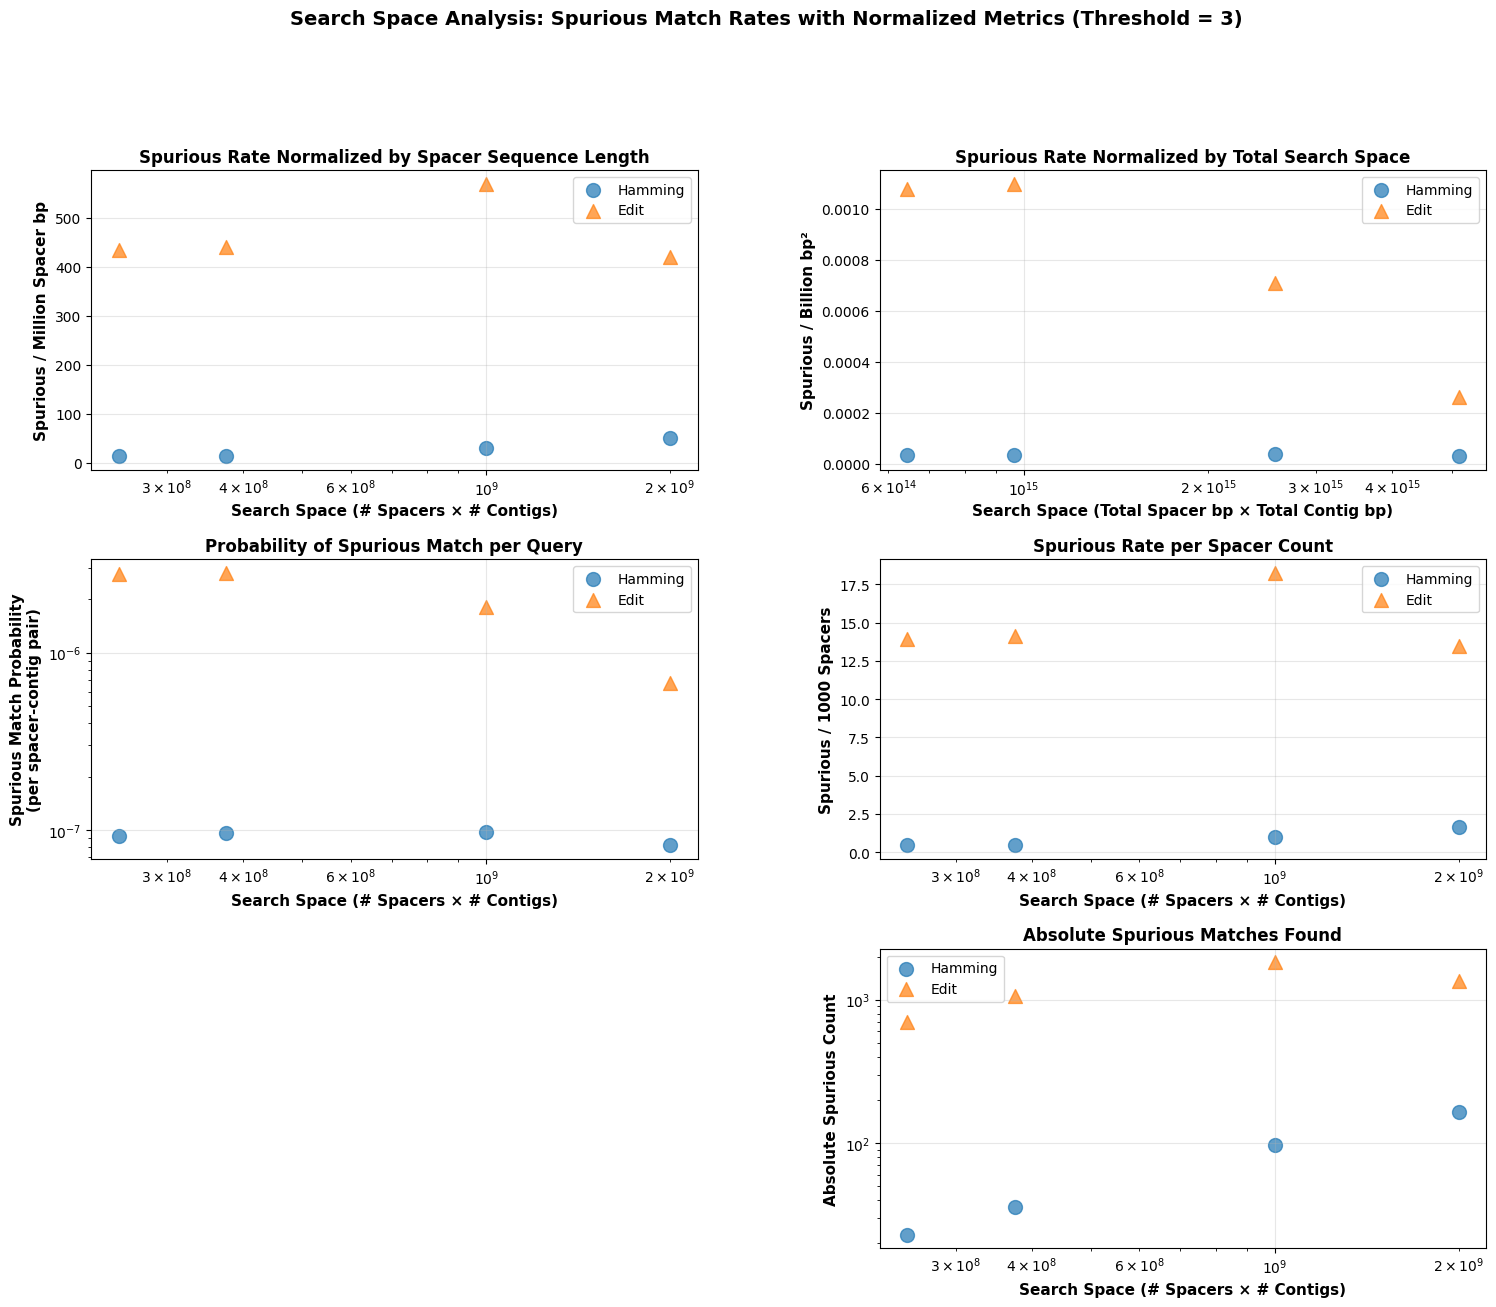

CORRELATION ANALYSIS (Pearson)
NEW normalized metrics (better for comparison):
Hamming per million spacer bp vs search space: 0.9986
Edit per million spacer bp vs search space: -0.0302
Hamming per billion bp² vs length product: -0.7568
Edit per billion bp² vs length product: -0.9951
Hamming probability vs search space: -0.7665
Edit probability vs search space: -0.9953


In [8]:
# Analyze search space effect on spurious match rates
import matplotlib.pyplot as plt
import numpy as np

# Extract search space metrics for each simulation
search_space_data = []

for results in comparison_results:
    sim_prefix = results['sim_prefix']
    sim_dir = f"results/simulated/{sim_prefix}"
    
    # Parse simulation name to get spacer and contig counts
    parts = sim_prefix.split('_')
    if len(parts) >= 4:
        try:
            n_spacers = int(parts[1])
            n_contigs = int(parts[3])
            
            # Get total sequence lengths from FASTA files
            spacer_file = f"{sim_dir}/simulated_data/simulated_spacers.fa"
            contig_file = f"{sim_dir}/simulated_data/simulated_contigs.fa"
            
            # Calculate total lengths
            import pyfastx
            spacers_fasta = pyfastx.Fasta(spacer_file)
            contigs_fasta = pyfastx.Fasta(contig_file)
            
            total_spacer_length = sum(len(seq) for seq in spacers_fasta)
            total_contig_length = sum(len(seq) for seq in contigs_fasta)
            
            # Get spurious rates at threshold=3 for both metrics
            hamming_df = results['hamming_results'].filter(pl.col('threshold') == 3)
            edit_df = results['edit_results'].filter(pl.col('threshold') == 3)
            
            if hamming_df.height > 0 and edit_df.height > 0:
                h_row = hamming_df.to_dicts()[0]
                e_row = edit_df.to_dicts()[0]
                
                h_spurious = h_row['positives_not_in_plan']
                e_spurious = e_row['positives_not_in_plan']
                
                # Calculate normalized spurious rates (independent of planned insertion count)
                # Rate 1: Spurious per million spacer bases
                h_per_million_spacer_bp = (h_spurious / total_spacer_length) * 1e6
                e_per_million_spacer_bp = (e_spurious / total_spacer_length) * 1e6
                
                # Rate 2: Spurious per billion bp² searched (total search space)
                search_space_bp2 = total_spacer_length * total_contig_length
                h_per_billion_bp2 = (h_spurious / search_space_bp2) * 1e9
                e_per_billion_bp2 = (e_spurious / search_space_bp2) * 1e9
                
                # Rate 3: Spurious probability (per spacer-contig pair)
                spacer_contig_pairs = n_spacers * n_contigs
                h_probability = h_spurious / spacer_contig_pairs
                e_probability = e_spurious / spacer_contig_pairs
                
                # Rate 4: Spurious per 1000 spacers
                h_per_1k_spacers = (h_spurious / n_spacers) * 1000
                e_per_1k_spacers = (e_spurious / n_spacers) * 1000
                
                search_space_data.append({
                    'sim_prefix': sim_prefix,
                    'n_spacers': n_spacers,
                    'n_contigs': n_contigs,
                    'count_product': n_spacers * n_contigs,
                    'total_spacer_length_bp': total_spacer_length,
                    'total_contig_length_bp': total_contig_length,
                    'length_product': total_spacer_length * total_contig_length,
                    # Absolute counts
                    'hamming_spurious_count': h_spurious,
                    'edit_spurious_count': e_spurious,
                    # NEW normalized metrics (independent of planned insertions)
                    'hamming_per_million_spacer_bp': h_per_million_spacer_bp,
                    'edit_per_million_spacer_bp': e_per_million_spacer_bp,
                    'hamming_per_billion_bp2': h_per_billion_bp2,
                    'edit_per_billion_bp2': e_per_billion_bp2,
                    'hamming_probability': h_probability,
                    'edit_probability': e_probability,
                    'hamming_per_1k_spacers': h_per_1k_spacers,
                    'edit_per_1k_spacers': e_per_1k_spacers,
                })
        except (ValueError, FileNotFoundError) as e:
            print(f"Skipping {sim_prefix}: {e}")

search_space_df = pl.DataFrame(search_space_data).sort('count_product')
print("Search Space Analysis (Threshold = 3):")
print("Basic metrics:")
print(search_space_df.select(['sim_prefix', 'n_spacers', 'n_contigs', 'count_product', 
                               'total_spacer_length_bp', 'total_contig_length_bp']))
print("NEW normalized metrics (independent of planned insertions):")
print(search_space_df.select(['sim_prefix', 
                               'hamming_per_million_spacer_bp', 'edit_per_million_spacer_bp',
                               'hamming_per_billion_bp2', 'edit_per_billion_bp2',
                               'hamming_probability', 'edit_probability']))

# Create comprehensive visualization with normalized metrics
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

count_products = search_space_df['count_product'].to_numpy()
length_products = search_space_df['length_product'].to_numpy()

# Plot 1: Spurious per million spacer bases vs count product
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(count_products, search_space_df['hamming_per_million_spacer_bp'].to_numpy(), 
            s=100, alpha=0.7, label='Hamming', color='#1f77b4', marker='o')
ax1.scatter(count_products, search_space_df['edit_per_million_spacer_bp'].to_numpy(), 
            s=100, alpha=0.7, label='Edit', color='#ff7f0e', marker='^')
ax1.set_xlabel('Search Space (# Spacers × # Contigs)', fontweight='bold', fontsize=11)
ax1.set_ylabel('Spurious / Million Spacer bp', fontweight='bold', fontsize=11)
ax1.set_title('Spurious Rate Normalized by Spacer Sequence Length', fontweight='bold', fontsize=12)
ax1.set_xscale('log')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Spurious per billion bp² vs length product
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(length_products, search_space_df['hamming_per_billion_bp2'].to_numpy(), 
            s=100, alpha=0.7, label='Hamming', color='#1f77b4', marker='o')
ax2.scatter(length_products, search_space_df['edit_per_billion_bp2'].to_numpy(), 
            s=100, alpha=0.7, label='Edit', color='#ff7f0e', marker='^')
ax2.set_xlabel('Search Space (Total Spacer bp × Total Contig bp)', fontweight='bold', fontsize=11)
ax2.set_ylabel('Spurious / Billion bp²', fontweight='bold', fontsize=11)
ax2.set_title('Spurious Rate Normalized by Total Search Space', fontweight='bold', fontsize=12)
ax2.set_xscale('log')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Spurious probability vs count product
ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(count_products, search_space_df['hamming_probability'].to_numpy(), 
            s=100, alpha=0.7, label='Hamming', color='#1f77b4', marker='o')
ax3.scatter(count_products, search_space_df['edit_probability'].to_numpy(), 
            s=100, alpha=0.7, label='Edit', color='#ff7f0e', marker='^')
ax3.set_xlabel('Search Space (# Spacers × # Contigs)', fontweight='bold', fontsize=11)
ax3.set_ylabel('Spurious Match Probability\n(per spacer-contig pair)', fontweight='bold', fontsize=11)
ax3.set_title('Probability of Spurious Match per Query', fontweight='bold', fontsize=12)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Plot 4: Spurious per 1000 spacers vs count product
ax4 = fig.add_subplot(gs[1, 1])
ax4.scatter(count_products, search_space_df['hamming_per_1k_spacers'].to_numpy(), 
            s=100, alpha=0.7, label='Hamming', color='#1f77b4', marker='o')
ax4.scatter(count_products, search_space_df['edit_per_1k_spacers'].to_numpy(), 
            s=100, alpha=0.7, label='Edit', color='#ff7f0e', marker='^')
ax4.set_xlabel('Search Space (# Spacers × # Contigs)', fontweight='bold', fontsize=11)
ax4.set_ylabel('Spurious / 1000 Spacers', fontweight='bold', fontsize=11)
ax4.set_title('Spurious Rate per Spacer Count', fontweight='bold', fontsize=12)
ax4.set_xscale('log')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

# Plot 6: Absolute counts (for reference)
ax6 = fig.add_subplot(gs[2, 1])
# For the semi-simulated - comment out the edit distance analysis, as we could not run sassy (our exhustive edit distance tool) 

ax6.scatter(count_products, search_space_df['hamming_spurious_count'].to_numpy(), 
            s=100, alpha=0.7, label='Hamming', color='#1f77b4', marker='o')
ax6.scatter(count_products, search_space_df['edit_spurious_count'].to_numpy(), 
            s=100, alpha=0.7, label='Edit', color='#ff7f0e', marker='^')
ax6.set_xlabel('Search Space (# Spacers × # Contigs)', fontweight='bold', fontsize=11)
ax6.set_ylabel('Absolute Spurious Count', fontweight='bold', fontsize=11)
ax6.set_title('Absolute Spurious Matches Found', fontweight='bold', fontsize=12)
ax6.set_xscale('log')
ax6.set_yscale('log')
ax6.legend(fontsize=10)
ax6.grid(True, alpha=0.3)

plt.suptitle('Search Space Analysis: Spurious Match Rates with Normalized Metrics (Threshold = 3)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.savefig('results/simulated/plots/search_space_analysis_normalized.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate correlations for the NEW metrics

print("CORRELATION ANALYSIS (Pearson)")
print("NEW normalized metrics (better for comparison):")
print(f"Hamming per million spacer bp vs search space: {np.corrcoef(count_products, search_space_df['hamming_per_million_spacer_bp'].to_numpy())[0, 1]:.4f}")
print(f"Edit per million spacer bp vs search space: {np.corrcoef(count_products, search_space_df['edit_per_million_spacer_bp'].to_numpy())[0, 1]:.4f}")
print(f"Hamming per billion bp² vs length product: {np.corrcoef(length_products, search_space_df['hamming_per_billion_bp2'].to_numpy())[0, 1]:.4f}")
print(f"Edit per billion bp² vs length product: {np.corrcoef(length_products, search_space_df['edit_per_billion_bp2'].to_numpy())[0, 1]:.4f}")
print(f"Hamming probability vs search space: {np.corrcoef(count_products, search_space_df['hamming_probability'].to_numpy())[0, 1]:.4f}")
print(f"Edit probability vs search space: {np.corrcoef(count_products, search_space_df['edit_probability'].to_numpy())[0, 1]:.4f}")



The normalized metrics (per million spacer bp, per billion bp², absolute counts)
are INDEPENDENT of how many planned insertions we made in the simulation.

Best metric depends on question:
  - Per million spacer bp: How often per unit of query sequence? (assumes spacer length distribution is similar to real data, and normal/sample-able?)
  - Per billion bp²: How often per unit of search space? (not sure this makes any sense i.e. gb squared?)
  - Probability: What's the chance for any given spacer-contig pair? (not sure if useful - dependent on number of planned insertions)
  - Per 1k spacers: Expected spurious matches per 1000 queries? (probably the most intuitive)

NOTE: these somewhat assume that spacers and contigs simulated are fairly "true to life" in terms of sequence complexity and repetitiveness. Moreover, the "n" per "x" assumes xs and ns are populations of distribution allowing for scaling/sampling that support extrapolations. In our case, most spacer lengths are fairly narrow range (20-40) with a normal/close-to-normal distribution. The contig lengths are more variable - we matched the contig length distribution to real HQ img/vr4 data, but for a people working on a more localized set of contigs (e.g. a single genome, or a small set of related genomes, or a metagenome from the same source), the repetitiveness and sequence complexity may differ significantly, affecting spurious match rates.  
That said, these metrics (above/plots) should still be informative in a comaprtive manner (i.e. hamming vs edit distance and up to what degree), as the use the same underlying data.


## Key Findings
**Key Metrics - Spurious Frequency** (all tool-independent, independent of planned insertion count):
   - **Hamming distance (≤3)**: 
     - High recall (>99% of planned matches detected)
     - Low spurious frequency: ~0.5-5 spurious matches per million spacer-contig pairs
     - Or equivalently: ~0.0001-0.001 spurious matches per Gbp² search space (spacer-bp × contig-bp)
     - Absolute counts scale with search space size (e.g., ~50-500 spurious in 100k spacers × 10k contigs)
   - **Edit distance (≤3)**: 
     - High recall (>99% of planned matches detected)
     - Higher spurious frequency: ~50-500 spurious matches per million spacer-contig pairs (10-100× higher than Hamming)
     - Or equivalently: ~0.01-0.1 spurious matches per Gbp² search space
     - Absolute counts scale with search space size (e.g., ~5,000-50,000 spurious in 100k spacers × 10k contigs)
   
5. **Distance Metric Impact**:
   - **Why Edit distance has higher spurious rates?** Edit distance allows indels, creating more opportunities for spurious matches
   - Search space size has predictable scaling effect on spurious match counts
   - Normalized metrics (per M pairs, per Gbp²) remain relatively stable across different simulation sizes
   - These are the rates you'd observe if using **any** of the tested alignment tools

6. **Invalid Alignment Rates** (true false positives):
   - Usually very low (<2%) with proper thresholds
   - Not all tools allow strict control over distance thresholds
   - Invalid alignments may result from tool limitations in reporting settings, not tool errors


## Semi synthetic dataset (all real spacers, many simulated contigs)
 real spacers, annd simulated contigs. NO insertions planned, this is only for estimating the spurios match rate.

In [10]:
# Semi-synthetic analysis: Real spacers vs simulated contigs
# This has NO planned insertions, only spurious matches expected

# Find semi-synthetic simulation
semi_syn_prefix = "ns_3826979_nc_421431_real_baseline"
semi_syn_dir = f"results/simulated/{semi_syn_prefix}"

print(f"Analyzing semi-synthetic dataset: {semi_syn_prefix}")
print("No planned insertions - all matches are spurious/chance matches\n")

# Get search space info for semi-synthetic
parts = semi_syn_prefix.split('_')
n_spacers = int(parts[1])
n_contigs = int(parts[3])

spacer_file = f"{semi_syn_dir}/simulated_data/simulated_spacers.fa"
contig_file = f"{semi_syn_dir}/simulated_data/simulated_contigs.fa"

import pyfastx
spacers_fasta = pyfastx.Fasta(spacer_file)
contigs_fasta = pyfastx.Fasta(contig_file)

total_spacer_length = sum(len(seq) for seq in spacers_fasta)
total_contig_length = sum(len(seq) for seq in contigs_fasta)

print("Search space:")
print(f"  Spacers: {n_spacers:,} (total: {total_spacer_length:,} bp)")
print(f"  Contigs: {n_contigs:,} (total: {total_contig_length:,} bp)")
print(f"  Count product: {n_spacers * n_contigs:,}")
print(f"  Length product: {total_spacer_length * total_contig_length:,}")

# Run threshold sweep for both metrics

print("Running compare-results for semi-synthetic dataset...")

# Hamming distance
print("--- HAMMING DISTANCE ---")
hamming_results_semisyn = analyze_simulation_threshold_sweep(
    semi_syn_dir, 
    distance_metric='hamming',
    thresholds=MAX_MISMATCHES_RANGE,
    verbose=False,
    logfile_dir=f"{semi_syn_dir}/logs",
    skip_existing=True
)

# Edit distance - COMMENTED OUT: sassy (exhaustive edit distance tool) too compute-intensive for this dataset
# print("--- EDIT DISTANCE ---")
# edit_results_semisyn = analyze_simulation_threshold_sweep(
#     semi_syn_dir,
#     distance_metric='edit',
#     thresholds=MAX_MISMATCHES_RANGE,
#     verbose=False,
#     logfile_dir=f"{semi_syn_dir}/logs"
# )

# Create placeholder for edit results (empty dataframe with same schema)
edit_results_semisyn = pl.DataFrame({
    'threshold': [],
    'recall_planned': [],
    'precision_augmented': [],
    'recall_augmented': [],
    'spurious_rate_pct': [],
    'invalid_rate_pct': [],
    'identified_pct': [],
    'missed_pct': [],
    'all_true_positives': [],
    'planned_true_positives': [],
    'positives_not_in_plan': [],
    'invalid_alignments': [],
    'false_negatives_planned': [],
    'ground_truth_planned': [],
    'ground_truth_augmented': [],
})

comparison_results_semisyn = [{
    'sim_prefix': semi_syn_prefix,
    'description': 'Real spacers, simulated contigs (no insertions) - Hamming only',
    'hamming_results': hamming_results_semisyn,
    'edit_results': edit_results_semisyn
}]

print("✓ Completed semi-synthetic analysis (Hamming distance only)")
print("NOTE: Edit distance analysis skipped - sassy too compute-intensive for this dataset")

# Display results
print("SEMI-SYNTHETIC RESULTS (All matches are spurious)")
print("Hamming Distance Results:")
print(hamming_results_semisyn)
# print("Edit Distance Results:")
# print(edit_results_semisyn)

Analyzing semi-synthetic dataset: ns_3826979_nc_421431_real_baseline
No planned insertions - all matches are spurious/chance matches

Search space:
  Spacers: 3,826,979 (total: 129,494,053 bp)
  Contigs: 421,431 (total: 21,470,981,225 bp)
  Count product: 1,612,807,586,949
  Length product: 2,780,364,380,712,154,925
Running compare-results for semi-synthetic dataset...
--- HAMMING DISTANCE ---
Analyzing hamming distance with threshold ≤ 0...
✓ Found existing results: performance_results_hamming_mm0.tsv
  Displaying INFO log entries:
    INFO: DEBUG logging enabled to file: results/simulated/ns_3826979_nc_421431_real_baseline/logs/compare_hamming_mm0.log
    INFO: Comparing tool results in results/simulated/ns_3826979_nc_421431_real_baseline
    INFO: Found 11 tool config files
    INFO: Successfully loaded 11 tool configurations
    INFO: Read 28407 total alignment results
    INFO: Loaded 0 ground truth annotations
    INFO: Ground truth file is empty (0 annotations)
    INFO: Calcula

ns_3826979_nc_421431_real_baseline - Summary at Threshold=3:
  Hamming: 54,388 spurious | 0.03 per M pairs | 0.0000 per Gbp²


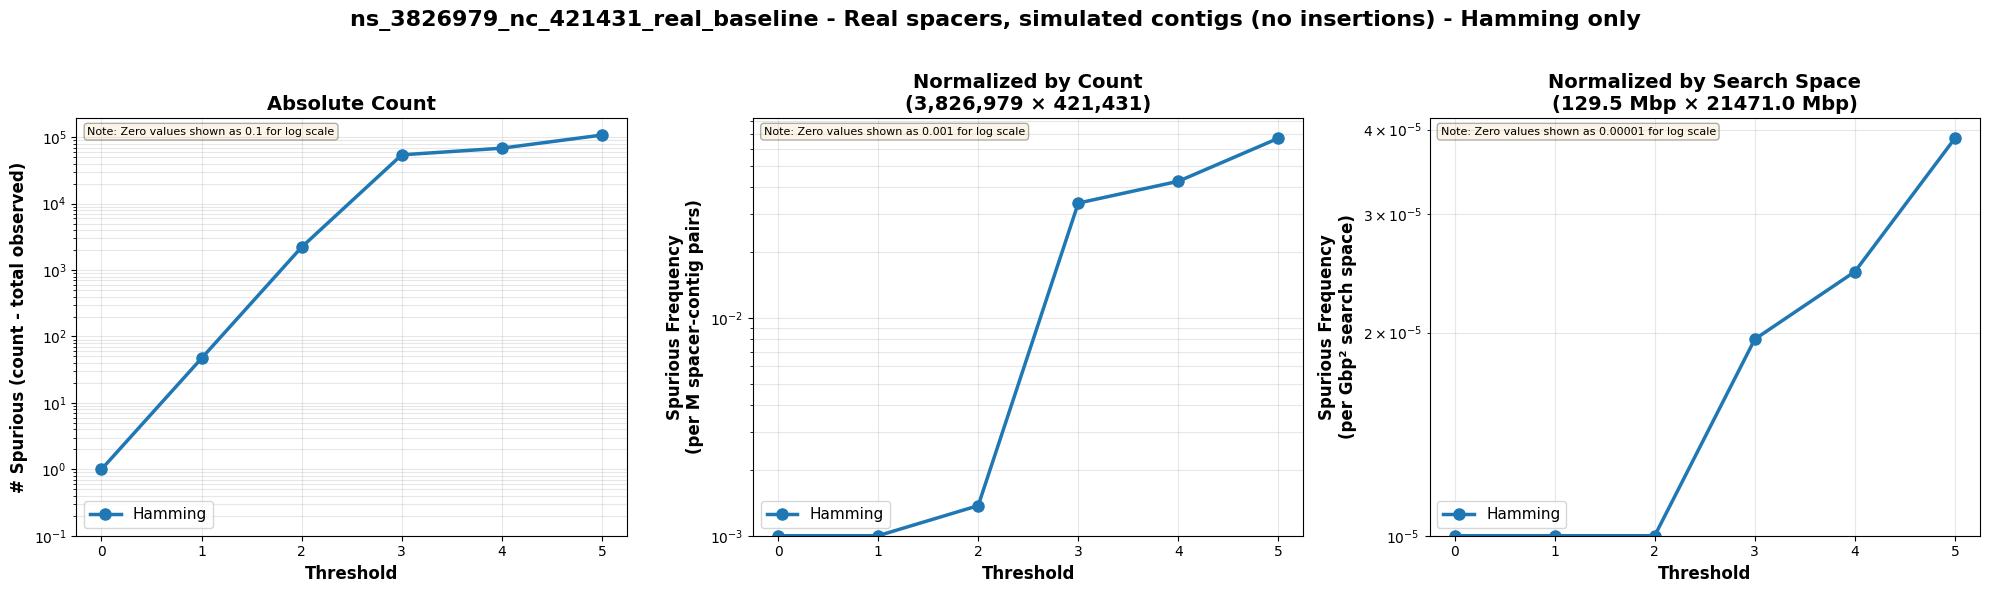

In [11]:
# Create plots for semi-synthetic results
summary_df_semisyn = create_comparison_plots(
    comparison_results_semisyn, 
    output_dir=f"{semi_syn_dir}/plots",
    no_summary=True
)

# # Calculate normalized metrics for semi-synthetic (Hamming only)
# semisyn_hamming = hamming_results_semisyn.filter(pl.col('threshold') == 3).to_dicts()[0]

# h_spurious_semisyn = semisyn_hamming['positives_not_in_plan']

# # Calculate normalized rates
# count_product_semisyn = n_spacers * n_contigs
# search_space_bp2_semisyn = total_spacer_length * total_contig_length
# h_per_M_pairs_semisyn = (h_spurious_semisyn / count_product_semisyn) * 1e6
# h_per_billion_bp2_semisyn = (h_spurious_semisyn / search_space_bp2_semisyn) * 1e9

# # Compare semi-synthetic normalized rates with simulated data
# print("COMPARISON: Semi-Synthetic vs Simulated Data (Threshold = 3, Hamming only)")

# print(f"Semi-Synthetic (Real spacers, {n_spacers:,} × {n_contigs:,} = {n_spacers*n_contigs:,}):")
# print(f"  Search space: {total_spacer_length:,} bp spacers × {total_contig_length:,} bp contigs")
# print(f"  Total search space: {search_space_bp2_semisyn:.2e} bp²")
# print("  Hamming:")
# print(f"    Absolute spurious count: {h_spurious_semisyn:,}")
# print(f"    Per M spacer-contig pairs: {h_per_M_pairs_semisyn:.2f}")
# print(f"    Per billion bp² searched: {h_per_billion_bp2_semisyn:.4f}")

# print(f"Simulated Data Average (across {len(comparison_results)} simulations at threshold=3):")
# h_per_bil_avg = np.mean(search_space_df['hamming_per_billion_bp2'].to_numpy())
# h_per_bil_std = np.std(search_space_df['hamming_per_billion_bp2'].to_numpy())

# print("  Hamming:")
# print(f"    Per billion bp² searched: {h_per_bil_avg:.4f} ± {h_per_bil_std:.4f}")

# # Create comparison visualization (Hamming only - 3 plots)
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# # Get simulated data metrics
# sim_h_count = search_space_df['hamming_spurious_count'].to_numpy()
# sim_h_per_M = search_space_df['hamming_per_1k_spacers'].to_numpy() * 1000  # Convert back to per M
# sim_h_per_bil = search_space_df['hamming_per_billion_bp2'].to_numpy()

# # Plot 1: Absolute spurious count - Hamming
# bp_h_count = ax1.boxplot([sim_h_count], positions=[1], widths=0.5, 
#                         patch_artist=True, showmeans=True,
#                         meanprops=dict(marker='D', markerfacecolor='red', markersize=8))
# for patch in bp_h_count['boxes']:
#     patch.set_facecolor('#1f77b4')
#     patch.set_alpha(0.6)

# ax1.scatter([2], [h_spurious_semisyn], s=200, marker='*', 
#             color='red', edgecolors='black', linewidths=2, zorder=5, 
#             label='Semi-Synthetic')
# ax1.set_xticks([1, 2])
# ax1.set_xticklabels(['Simulated\n(Random Insertions)', 'Semi-Synthetic\n(Real Spacers)'])
# ax1.set_ylabel('Spurious Frequency (count)', fontweight='bold', fontsize=12)
# ax1.set_title('Hamming Distance (≤3) - Absolute Count', fontweight='bold', fontsize=14)
# ax1.set_yscale('log')
# ax1.grid(True, alpha=0.3, axis='y', which='both')
# ax1.legend()

# # Plot 2: Per M pairs - Hamming
# bp_h_M = ax2.boxplot([sim_h_per_M], positions=[1], widths=0.5,
#                       patch_artist=True, showmeans=True,
#                       meanprops=dict(marker='D', markerfacecolor='red', markersize=8))
# for patch in bp_h_M['boxes']:
#     patch.set_facecolor('#1f77b4')
#     patch.set_alpha(0.6)

# ax2.scatter([2], [h_per_M_pairs_semisyn], s=200, marker='*',
#             color='red', edgecolors='black', linewidths=2, zorder=5,
#             label='Semi-Synthetic')
# ax2.set_xticks([1, 2])
# ax2.set_xticklabels(['Simulated\n(Random Insertions)', 'Semi-Synthetic\n(Real Spacers)'])
# ax2.set_ylabel('Spurious Frequency\n(per M spacer-contig pairs)', fontweight='bold', fontsize=12)
# ax2.set_title('Hamming Distance (≤3) - Normalized by Count', fontweight='bold', fontsize=14)
# ax2.set_yscale('log')
# ax2.grid(True, alpha=0.3, axis='y', which='both')
# ax2.legend()


# plt.suptitle('Spurious Frequency (Hamming only): Simulated vs Semi-Synthetic', 
#              fontsize=16, fontweight='bold')
# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.savefig(f'{semi_syn_dir}/plots/semisynthetic_comparison_normalized_hamming.png', dpi=150, bbox_inches='tight')
# plt.show()


### NOTE!
blastn and indelfree_indexed both timed out for this run. Altough this is using the all_tools_combined aggregate, which includes bt1, which we observed has relatively high recall up to 3 (but can not do >3 mismatches). So the results for 4 and 5 above are probably an underestimate...

## Multi-Metric Distance Analysis for All Unique Alignments

This section analyzes all unique alignments across tools using **three** distance metrics simultaneously:
1. **Hamming distance** - substitutions only, no indels
2. **Edit distance** - minimal edit distance (substitutions + indels) via edlib
3. **Gap-affine distance** - gap-affine alignment via parasail (substitutions + indels with gap penalties)

For each unique alignment region reported by any tool, we calculate all three distances and classify based on ground truth matching (with coordinate tolerance). This provides a comprehensive view of how different distance metrics evaluate the same alignments.

**Output columns:**
- `classification`: positive_in_plan, positive_not_in_plan, or invalid_alignment
- `alignment_idx`: Unique identifier for this specific alignment (spacer+contig+coords+strand)
- `region_idx`: Unique identifier for fuzzy-boundary region (using coordinate tolerance)
- `tools`: List of tools that reported this alignment
- `distance_hamming`, `distance_edit`, `distance_gap_affine`: Calculated distances
- `spacer_seq`, `contig_seq`: Sequences used for alignment
- `spacer_id`, `contig_id`, `start`, `end`, `strand`: Alignment coordinates
- `planned_mismatches`: From ground truth (if available), else recalculated hamming

**Use case:** This allows threshold-based filtering later (e.g., "show me all alignments with edit ≤3 AND hamming ≤2") without re-running the full analysis.

In [2]:
import sys
sys.path.insert(0, '/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/src')
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

os.chdir('/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/')

import polars as pl
from bench.utils.functions import (
    read_fasta,
    read_results,
    populate_pldf_withseqs_needletail,
    calculate_hamming_distance,
    calculate_edit_distance,
    calculate_gap_affine_edit,
    match_intervals_with_tolerance,
    vstack_easy,
)
from bench.commands.compare_results import merge_overlapping_intervals
from bench.utils.tool_commands import load_tool_configs
import polars as pl
from pathlib import Path

def calculate_all_distances_for_alignment(
    spacer_seq: str,
    contig_seq: str,
    strand: bool,
    gap_open: int = 5,
    gap_extend: int = 5,
) -> dict:
    """
    Calculate all three distance metrics for a single alignment.
    
    Args:
        spacer_seq: Query sequence
        contig_seq: Target sequence (already trimmed to region)
        strand: Reverse complement flag
        gap_open: Gap opening penalty for gap-affine
        gap_extend: Gap extension penalty for gap-affine
        
    Returns:
        Dictionary with hamming, edit, and gap_affine distances
    """
    # Calculate hamming distance
    hamming_dist = calculate_hamming_distance(
        spacer_seq=spacer_seq,
        contig_seq=contig_seq,
        strand=strand,
        start=None,
        end=None,
        silent=True,
    )
    
    # Calculate edit distance (minimal)
    edit_dist = calculate_edit_distance(
        spacer_seq=spacer_seq,
        contig_seq=contig_seq,
        strand=strand,
        start=None,
        end=None,
    )
    
    # Calculate gap-affine distance
    gap_affine_dist = calculate_gap_affine_edit(
        spacer_seq=spacer_seq,
        contig_seq=contig_seq,
        strand=strand,
        start=None,
        end=None,
        gap_open=gap_open,
        gap_extend=gap_extend,
    )
    
    return {
        'distance_hamming': hamming_dist,
        'distance_edit': edit_dist,
        'distance_gap_affine': gap_affine_dist,
    }


def analyze_simulation_multi_metric(
    sim_dir: str,
    max_distance_threshold: int = 5,
    coordinate_tolerance: int = 5,
    gap_open: int = 5,
    gap_extend: int = 5,
) -> pl.DataFrame:
    """
    Analyze all unique alignments in a simulation using three distance metrics.
    
    Args:
        sim_dir: Path to simulation directory
        max_distance_threshold: Maximum distance to classify as valid (applied to ALL metrics)
        coordinate_tolerance: Tolerance for matching to ground truth
        gap_open: Gap opening penalty for gap-affine alignment
        gap_extend: Gap extension penalty for gap-affine alignment
        
    Returns:
        DataFrame with all unique alignments and their distances calculated via all 3 metrics
    """
    sim_path = Path(sim_dir)
    
    # Load ground truth (if exists)
    gt_file = sim_path / "simulated_data" / "planned_ground_truth.tsv"
    if gt_file.exists():
        ground_truth = pl.read_csv(str(gt_file), separator='\t')
        print(f"Loaded ground truth: {ground_truth.height} entries")
    else:
        ground_truth = pl.DataFrame({
            'spacer_id': [],
            'contig_id': [],
            'start': [],
            'end': [],
            'strand': [],
            'mismatches': [],
        })
        print("No ground truth file found - all alignments will be 'not_in_plan'")
    
    # Load tool configs and results
    tool_configs_dir = "/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/tool_configs"
    tools = load_tool_configs(tool_configs_dir)
    
    # Filter to tools that have output files in this simulation
    raw_outputs_dir = sim_path / "raw_outputs"
    available_tools = {}
    for tool_name, tool_config in tools.items():
        # Extract just the filename from the output_file path (after {output_dir}/)
        output_filename = Path(tool_config['output_file']).name
        output_file = raw_outputs_dir / output_filename
        if output_file.exists():
            available_tools[tool_name] = tool_config.copy()
            available_tools[tool_name]['output_file'] = str(output_file)
    
    print(f"Found {len(available_tools)} tools with results: {list(available_tools.keys())}")
    
    # Debug: show what we found
    if len(available_tools) > 0:
        print("Sample tool config:")
        first_tool = list(available_tools.keys())[0]
        print(f"  {first_tool}: {available_tools[first_tool]['output_file']}")
    
    # Read all tool results
    spacer_file = str(sim_path / "simulated_data" / "simulated_spacers.fa")
    contig_file = str(sim_path / "simulated_data" / "simulated_contigs.fa")
    
    # Load spacer lengths for filtering - convert dict to DataFrame
    spacer_lengths_dict = read_fasta(spacer_file)
    spacer_lengths = pl.DataFrame({
        'spacer_id': list(spacer_lengths_dict.keys()),
        'length': [len(seq) for seq in spacer_lengths_dict.values()]
    })
    
    print("Reading tool results...")
    all_tool_results = read_results(
        tools=available_tools,
        max_mismatches=max_distance_threshold,
        spacer_lendf=spacer_lengths,
        ref_file=None,
        threads=8,
        use_duckdb=True,
    )
    
    print(f"Total alignments from all tools: {all_tool_results.height}")
    print(f"unique alignments from all tools: {all_tool_results.select(['spacer_id', 'contig_id', 'start', 'end', 'strand', 'mismatches']).unique().height}")

    # Get unique alignments (by coordinates)
    unique_alignments = all_tool_results.select(
        ["spacer_id", "contig_id", "start", "end", "strand", "mismatches"]
    ).unique()
    
    print(f"Unique alignment regions: {unique_alignments.height}")
    
    # Add alignment index
    unique_alignments = unique_alignments.with_row_index("alignment_idx")
    
    # Create region index by merging overlapping intervals
    merged_regions = merge_overlapping_intervals(
        unique_alignments, tolerance=coordinate_tolerance
    )
    merged_regions = merged_regions.with_row_index("region_idx")
    
    # Join back to get region_idx for each alignment
    unique_alignments = unique_alignments.join(
        merged_regions,
        on=["spacer_id", "contig_id", "strand"],
        how="left",
        suffix="_region"
    ).filter(
        # Keep only if alignment falls within merged region
        (pl.col("start") >= pl.col("start_region") - coordinate_tolerance) &
        (pl.col("start") <= pl.col("end_region") + coordinate_tolerance)
    ).select(
        [c for c in unique_alignments.columns] + ["region_idx"]
    )
    
    print(f"Merged into {merged_regions.height} unique regions (with {coordinate_tolerance}bp tolerance)")
    
    # Match to ground truth
    if ground_truth.height > 0:
        matches_with_tolerance = match_intervals_with_tolerance(
            ground_truth=ground_truth,
            tool_results=unique_alignments,
            tolerance=coordinate_tolerance,
        )
        
        # Join ground truth mismatches to matches
        matches_with_gt_data = matches_with_tolerance.join(
            ground_truth.select(["spacer_id", "contig_id", "start", "end", "strand", "mismatches"]),
            left_on=["spacer_id", "contig_id", "start_gt", "end_gt", "strand"],
            right_on=["spacer_id", "contig_id", "start", "end", "strand"],
            how="left",
            suffix="_gt_data"
        ).rename({"mismatches": "mismatches_gt"})
        
        # Add classification to unique alignments
        unique_alignments = unique_alignments.join(
            matches_with_gt_data.select([
                "spacer_id", "contig_id", "start", "end", "strand",
                "classification", "start_gt", "end_gt", "mismatches_gt"
            ]),
            on=["spacer_id", "contig_id", "start", "end", "strand"],
            how="left"
        )
        
        # Fill in classifications for non-matches (will verify later)
        unique_alignments = unique_alignments.with_columns(
            pl.col("classification").fill_null("needs_verification")
        )
    else:
        # No ground truth - all alignments need verification
        unique_alignments = unique_alignments.with_columns([
            pl.lit("needs_verification").alias("classification"),
            pl.lit(None).cast(pl.Int64).alias("start_gt"),
            pl.lit(None).cast(pl.Int64).alias("end_gt"),
            pl.lit(None).cast(pl.Int64).alias("mismatches_gt"),
        ])
    
    # Load sequences for all alignments
    print("Loading sequences for distance calculations...")
    unique_alignments = populate_pldf_withseqs_needletail(
        unique_alignments,
        seqfile=spacer_file,
        idcol="spacer_id",
        seqcol="spacer_seq",
        trim_to_region=False,
        reverse_by_strand_col=False,
    )
    
    unique_alignments = populate_pldf_withseqs_needletail(
        unique_alignments,
        seqfile=contig_file,
        idcol="contig_id",
        seqcol="contig_seq",
        trim_to_region=True,
        reverse_by_strand_col=True,
    )
    
    # Calculate all three distance metrics for each alignment
    print("Calculating all distance metrics (hamming, edit, gap_affine)...")
    unique_alignments = unique_alignments.with_columns(
        pl.struct(
            pl.col("spacer_seq"),
            pl.col("contig_seq"),
            pl.col("strand")
        ).map_elements(
            lambda x: calculate_all_distances_for_alignment(
                spacer_seq=x["spacer_seq"],
                contig_seq=x["contig_seq"],
                strand=x["strand"],
                gap_open=gap_open,
                gap_extend=gap_extend,
            ),
            return_dtype=pl.Struct({
                'distance_hamming': pl.Int64,
                'distance_edit': pl.Int64,
                'distance_gap_affine': pl.Int64,
            })
        ).alias("distances")
    ).unnest("distances")
    
    # Update classification based on all three metrics
    # Only mark as invalid if ALL three metrics exceed threshold
    unique_alignments = unique_alignments.with_columns(
        pl.when(pl.col("classification") == "needs_verification")
        .then(
            pl.when(
                (pl.col("distance_hamming") > max_distance_threshold) &
                (pl.col("distance_edit") > max_distance_threshold) &
                (pl.col("distance_gap_affine") > max_distance_threshold)
            )
            .then(pl.lit("invalid_alignment"))
            .otherwise(pl.lit("positive_not_in_plan"))
        )
        .otherwise(pl.col("classification"))
        .alias("classification")
    )
    
    # Add planned_mismatches column (from GT if available, else recalculated hamming)
    unique_alignments = unique_alignments.with_columns(
        pl.when(pl.col("mismatches_gt").is_not_null())
        .then(pl.col("mismatches_gt"))
        .otherwise(pl.col("distance_hamming"))
        .alias("planned_mismatches")
    )
    
    # Collect which tools reported each alignment
    tool_assignments = all_tool_results.group_by(
        ["spacer_id", "contig_id", "start", "end", "strand"]
    ).agg(
        pl.col("tool").unique().alias("tools")
    )
    
    # Join tools list
    unique_alignments = unique_alignments.join(
        tool_assignments,
        on=["spacer_id", "contig_id", "start", "end", "strand"],
        how="left"
    )
    
    # Select final columns in desired order
    final_columns = [
        "alignment_idx",
        "region_idx",
        "classification",
        "tools",
        "spacer_id",
        "contig_id",
        "start",
        "end",
        "strand",
        "distance_hamming",
        "distance_edit",
        "distance_gap_affine",
        "planned_mismatches",
        "start_gt",
        "end_gt",
        "spacer_seq",
        "contig_seq",
    ]
    
    result = unique_alignments.select(final_columns)
    
    print("Classification summary:")
    print(result['classification'].value_counts(sort=True))
    
    return result


In [ ]:

# Select simulations to process
sims_to_process = [
    "ns_50000_nc_5000",
    "ns_75000_nc_5000",
    "ns_1000_nc_10000",
    "ns_100000_nc_10000",
    "ns_100000_nc_20000",
    "ns_3826979_nc_421431_real_baseline"
]

all_sim_results = {}

for sim_prefix in sims_to_process:
    sim_dir = f"results/simulated/{sim_prefix}"
    
    print(f"Processing: {sim_prefix}")
    
    try:
        # Run multi-metric analysis
        results = analyze_simulation_multi_metric(
            sim_dir=sim_dir,
            max_distance_threshold=5,
            coordinate_tolerance=5,
            gap_open=5,
            gap_extend=5,
        )
        
        # Save results
        output_file = f"{sim_dir}/multi_metric_distances.parquet"
        results.write_parquet(output_file)
        print(f"Saved to: {output_file}")
        
        all_sim_results[sim_prefix] = results
        
    except Exception as e:
        print(f"Error processing {sim_prefix}: {e}")
        continue


Processing: ns_50000_nc_5000
Loaded ground truth: 149843 entries
Found 11 tools with results: ['blastn', 'bowtie1', 'bowtie2', 'indelfree_bruteforce', 'indelfree_indexed', 'minimap2', 'mmseqs2', 'mummer4', 'sassy', 'strobealign', 'x_mapper']
Sample tool config:
  blastn: results/simulated/ns_50000_nc_5000/raw_outputs/blastn_output.tsv
Reading tool results...
Total alignments from all tools: 1121073
unique alignments from all tools: 353161
Unique alignment regions: 353161
Merged into 267768 unique regions (with 5bp tolerance)
Loading sequences for distance calculations...
Calculating all distance metrics (hamming, edit, gap_affine)...
Classification summary:
shape: (3, 2)
┌──────────────────────┬────────┐
│ classification       ┆ count  │
│ ---                  ┆ ---    │
│ str                  ┆ u64    │
╞══════════════════════╪════════╡
│ positive_in_plan     ┆ 231929 │
│ positive_not_in_plan ┆ 121229 │
│ invalid_alignment    ┆ 3      │
└──────────────────────┴────────┘
Saved to: resu

In [3]:
# Test on small simulation
test_sim = "ns_50000_nc_5000"
test_sim_dir = f"results/simulated/{test_sim}"

# print(f"Testing on: {test_sim}")
# print(f"Directory: {test_sim_dir}")

# # Run multi-metric analysis
# multi_metric_results = analyze_simulation_multi_metric(
#     sim_dir=test_sim_dir,
#     max_distance_threshold=5,
#     coordinate_tolerance=5,
#     gap_open=5,
#     gap_extend=5,
# )

# # Save results
# output_file = f"{test_sim_dir}/multi_metric_distances.parquet"
# multi_metric_results.write_parquet(output_file)
multi_metric_results = pl.read_parquet(f"{test_sim_dir}/multi_metric_distances.parquet")
# print(f"\nSaved results to: {output_file}")

In [4]:
multi_metric_results.head(10)

alignment_idx,region_idx,classification,tools,spacer_id,contig_id,start,end,strand,distance_hamming,distance_edit,distance_gap_affine,planned_mismatches,start_gt,end_gt,spacer_seq,contig_seq
u64,u64,str,list[str],str,str,u32,u32,bool,i64,i64,i64,i64,i64,i64,str,str
56371,77583,"""positive_in_plan""","[""blastn"", ""bowtie1"", … ""x_mapper""]","""d1184075_spacer_5503""","""d1184075_contig_2347""",35797,35828,true,0,0,0,0,35797,35828,"""ATTGGCCATTATTAATTTAGGACGCAATTGG""","""CCAATTGCGTCCTAAATTAATAATGGCCAAT"""
61785,40313,"""positive_not_in_plan""","[""sassy""]","""d1184075_spacer_6632""","""d1184075_contig_2248""",110249,110277,true,14,5,5,14,null,null,"""CCTGGTAATTTGTACTAACGTTGCGCACT""","""AGTGCGAACGTGAGTATCAAATTACAGC"""
62632,62081,"""positive_not_in_plan""","[""sassy""]","""d1184075_spacer_39259""","""d1184075_contig_352""",13234,13258,false,9,5,5,9,null,null,"""TGCCCACGCAACCTCTGGCAAGCCG""","""TGCCCTCTCAATCTCGGCAAGGCG"""
61104,24600,"""positive_in_plan""","[""indelfree_bruteforce"", ""indelfree_indexed""]","""d1184075_spacer_22423""","""d1184075_contig_3645""",18292,18319,false,5,5,5,5,18292,18319,"""GACTTAGTTGACCTAGCCAGAATTTCG""","""GATTTAGTTGCCCTAGTCAGCATTTCT"""
63775,1739,"""positive_in_plan""","[""blastn"", ""mmseqs2"", ""mummer4""]","""d1184075_spacer_19174""","""d1184075_contig_882""",71259,71291,true,2,2,2,4,71259,71293,"""ATGCCTTAAGCGACGAAAGCGTGAATTCTTAACG""","""CGTTAAGAATTCACGCTTTCGTCGCTTAAGGC"""
56382,245028,"""positive_in_plan""","[""blastn"", ""bowtie1"", … ""x_mapper""]","""d1184075_spacer_44592""","""d1184075_contig_2858""",38368,38400,false,0,0,0,0,38368,38400,"""TGGTATTCACGATCCTCAACTCAGCTTGGGAC""","""TGGTATTCACGATCCTCAACTCAGCTTGGGAC"""
63764,238787,"""positive_in_plan""","[""blastn"", ""mummer4""]","""d1184075_spacer_26651""","""d1184075_contig_665""",67941,67977,false,2,2,2,2,67940,67977,"""TGGCACCGGAGAAGCAGGGGCTTGCACACCCCTTTAA""","""GGCACCGGGGAAGCAGGGGCTTGCACACCCCTTTAA"""
55898,64619,"""positive_in_plan""","[""blastn"", ""bowtie1"", … ""sassy""]","""d1184075_spacer_36826""","""d1184075_contig_2903""",24359,24390,true,2,2,2,2,24359,24390,"""CCTACCTAAGTGCCCCACGTCTAAGTGTGCC""","""GGCACAGTTAGACGTGGGTCACTTAGGTAGG"""
57502,193091,"""positive_in_plan""","[""blastn"", ""bowtie1"", … ""strobealign""]","""d1184075_spacer_19149""","""d1184075_contig_1196""",7734,7769,true,2,2,2,2,7734,7769,"""GATTAGAATTACAGATTAGAACCAAAAGTACAACT""","""AGTTTTACTTTTGGTTCTAATCTGTAATTATAATC"""


### Analysis of Distance Metric Relationships
1. How often do the three metrics agree on distance values?
2. What's the distribution of differences between metrics?
3. For threshold-based filtering, how would results change with different metric choices?  

NOTE: because of the way we called some tools, the maximum mismatches we simulated (<=5 for most, and <=3 for some) we can't really estimate these questions. This is mostly to showcase within the <=3 range (and to confirm there is very little difference between the gap_affine (as we use it) to the min edit...)

DISTANCE METRIC RELATIONSHIP ANALYSIS
Distance metric statistics:
shape: (1, 3)
┌──────────────┬───────────┬─────────────────┐
│ hamming_mean ┆ edit_mean ┆ gap_affine_mean │
│ ---          ┆ ---       ┆ ---             │
│ f64          ┆ f64       ┆ f64             │
╞══════════════╪═══════════╪═════════════════╡
│ 6.118479     ┆ 3.446825  ┆ 3.446825        │
└──────────────┴───────────┴─────────────────┘
Distance metric ranges:
shape: (1, 6)
┌─────────────┬─────────────┬──────────┬──────────┬────────────────┬────────────────┐
│ hamming_min ┆ hamming_max ┆ edit_min ┆ edit_max ┆ gap_affine_min ┆ gap_affine_max │
│ ---         ┆ ---         ┆ ---      ┆ ---      ┆ ---            ┆ ---            │
│ i64         ┆ i64         ┆ i64      ┆ i64      ┆ i64            ┆ i64            │
╞═════════════╪═════════════╪══════════╪══════════╪════════════════╪════════════════╡
│ 0           ┆ 34          ┆ 0        ┆ 6        ┆ 0              ┆ 6              │
└─────────────┴─────────────┴────────

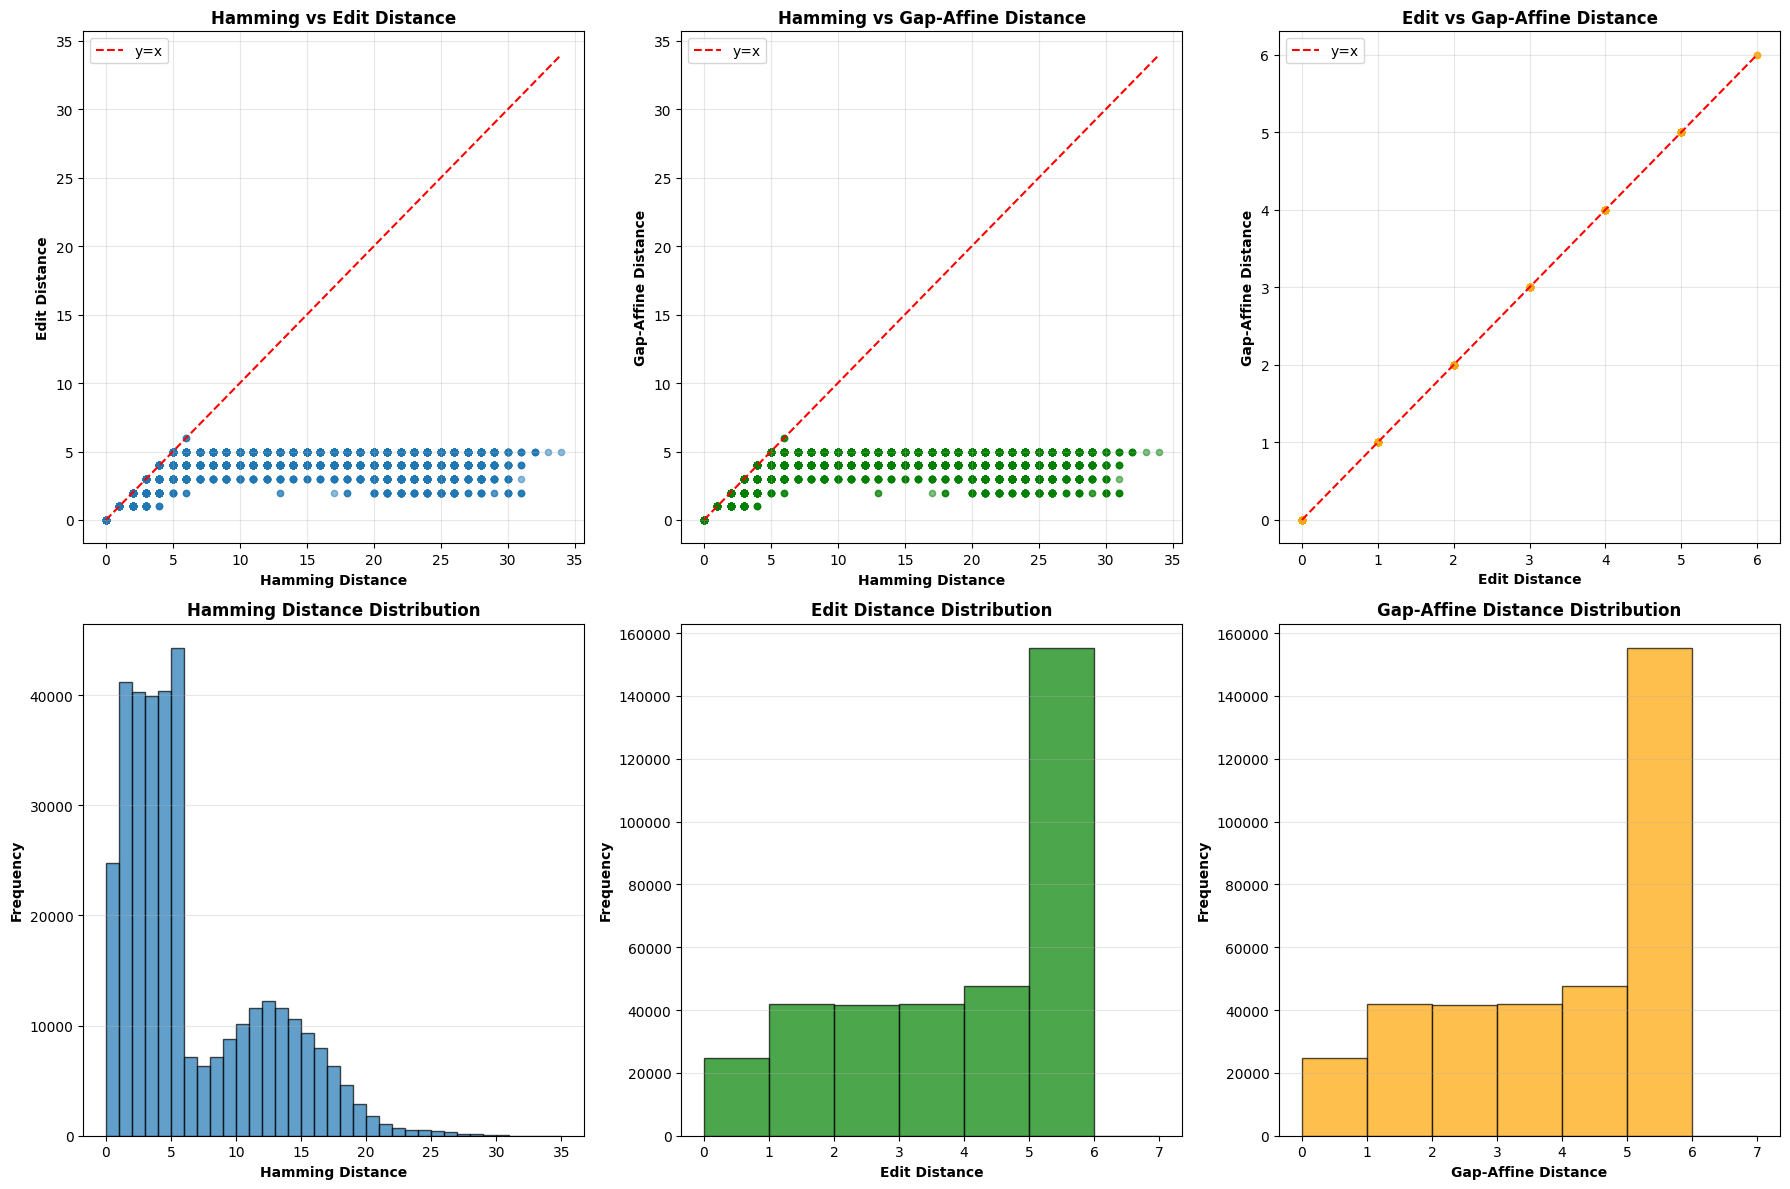

THRESHOLD ANALYSIS

Threshold ≤ 1:
  Hamming: 65998 alignments (18.7%)
  Edit: 66813 alignments (18.9%)
  Gap-affine: 66813 alignments (18.9%)

Threshold ≤ 2:
  Hamming: 106319 alignments (30.1%)
  Edit: 108582 alignments (30.7%)
  Gap-affine: 108582 alignments (30.7%)

Threshold ≤ 3:
  Hamming: 146232 alignments (41.4%)
  Edit: 150389 alignments (42.6%)
  Gap-affine: 150389 alignments (42.6%)

Threshold ≤ 4:
  Hamming: 186632 alignments (52.8%)
  Edit: 197946 alignments (56.0%)
  Gap-affine: 197946 alignments (56.0%)

Threshold ≤ 5:
  Hamming: 230887 alignments (65.4%)
  Edit: 353158 alignments (100.0%)
  Gap-affine: 353158 alignments (100.0%)


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Analyze distance metric relationships
def analyze_distance_relationships(results_df: pl.DataFrame):
    """
    Analyze how the three distance metrics relate to each other.
    """
    print("DISTANCE METRIC RELATIONSHIP ANALYSIS")
    
    # Basic statistics
    print("Distance metric statistics:")
    print(results_df.select([
        pl.col("distance_hamming").mean().alias("hamming_mean"),
        pl.col("distance_edit").mean().alias("edit_mean"),
        pl.col("distance_gap_affine").mean().alias("gap_affine_mean"),
    ]))
    

    
    print("Distance metric ranges:")
    print(results_df.select([
        pl.col("distance_hamming").min().alias("hamming_min"),
        pl.col("distance_hamming").max().alias("hamming_max"),
        pl.col("distance_edit").min().alias("edit_min"),
        pl.col("distance_edit").max().alias("edit_max"),
        pl.col("distance_gap_affine").min().alias("gap_affine_min"),
        pl.col("distance_gap_affine").max().alias("gap_affine_max"),
    ]))
    
    # Count alignments where all metrics agree
    results_df_agree = results_df.with_columns([
        (pl.col("distance_hamming") == pl.col("distance_edit")).alias("hamming_eq_edit"),
        (pl.col("distance_hamming") == pl.col("distance_gap_affine")).alias("hamming_eq_gap_affine"),
        (pl.col("distance_edit") == pl.col("distance_gap_affine")).alias("edit_eq_gap_affine"),
        (
            (pl.col("distance_hamming") == pl.col("distance_edit")) &
            (pl.col("distance_edit") == pl.col("distance_gap_affine"))
        ).alias("all_agree"),
    ])
    
    print("Metric agreement:")
    print(f"  All three metrics agree: {results_df_agree['all_agree'].sum()} / {results_df_agree.height} ({results_df_agree['all_agree'].mean()*100:.1f}%)")
    print(f"  Hamming == Edit: {results_df_agree['hamming_eq_edit'].sum()} ({results_df_agree['hamming_eq_edit'].mean()*100:.1f}%)")
    print(f"  Hamming == Gap-affine: {results_df_agree['hamming_eq_gap_affine'].sum()} ({results_df_agree['hamming_eq_gap_affine'].mean()*100:.1f}%)")
    print(f"  Edit == Gap-affine: {results_df_agree['edit_eq_gap_affine'].sum()} ({results_df_agree['edit_eq_gap_affine'].mean()*100:.1f}%)")
    
    # Analyze cases where metrics disagree
    disagreements = results_df_agree.filter(~pl.col("all_agree"))
    if disagreements.height > 0:
        print(f"\nDisagreement cases: {disagreements.height}")
        print("Sample disagreements:")
        print(disagreements.select([
            "spacer_id", "contig_id", "start", "end",
            "distance_hamming", "distance_edit", "distance_gap_affine",
            "classification"
        ]).head(10))
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Extract data as numpy arrays for plotting
    hamming = results_df["distance_hamming"].to_numpy()
    edit = results_df["distance_edit"].to_numpy()
    gap_affine = results_df["distance_gap_affine"].to_numpy()
    
    # Plot 1: Hamming vs Edit
    axes[0, 0].scatter(hamming, edit, alpha=0.5, s=20)
    axes[0, 0].plot([0, max(hamming.max(), edit.max())], [0, max(hamming.max(), edit.max())], 'r--', label='y=x')
    axes[0, 0].set_xlabel('Hamming Distance', fontweight='bold')
    axes[0, 0].set_ylabel('Edit Distance', fontweight='bold')
    axes[0, 0].set_title('Hamming vs Edit Distance', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Hamming vs Gap-affine
    axes[0, 1].scatter(hamming, gap_affine, alpha=0.5, s=20, color='green')
    axes[0, 1].plot([0, max(hamming.max(), gap_affine.max())], [0, max(hamming.max(), gap_affine.max())], 'r--', label='y=x')
    axes[0, 1].set_xlabel('Hamming Distance', fontweight='bold')
    axes[0, 1].set_ylabel('Gap-Affine Distance', fontweight='bold')
    axes[0, 1].set_title('Hamming vs Gap-Affine Distance', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Edit vs Gap-affine
    axes[0, 2].scatter(edit, gap_affine, alpha=0.5, s=20, color='orange')
    axes[0, 2].plot([0, max(edit.max(), gap_affine.max())], [0, max(edit.max(), gap_affine.max())], 'r--', label='y=x')
    axes[0, 2].set_xlabel('Edit Distance', fontweight='bold')
    axes[0, 2].set_ylabel('Gap-Affine Distance', fontweight='bold')
    axes[0, 2].set_title('Edit vs Gap-Affine Distance', fontweight='bold')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Plot 4: Distribution of Hamming distances
    axes[1, 0].hist(hamming, bins=range(0, int(hamming.max())+2), alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('Hamming Distance', fontweight='bold')
    axes[1, 0].set_ylabel('Frequency', fontweight='bold')
    axes[1, 0].set_title('Hamming Distance Distribution', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Plot 5: Distribution of Edit distances
    axes[1, 1].hist(edit, bins=range(0, int(edit.max())+2), alpha=0.7, color='green', edgecolor='black')
    axes[1, 1].set_xlabel('Edit Distance', fontweight='bold')
    axes[1, 1].set_ylabel('Frequency', fontweight='bold')
    axes[1, 1].set_title('Edit Distance Distribution', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # Plot 6: Distribution of Gap-affine distances
    axes[1, 2].hist(gap_affine, bins=range(0, int(gap_affine.max())+2), alpha=0.7, color='orange', edgecolor='black')
    axes[1, 2].set_xlabel('Gap-Affine Distance', fontweight='bold')
    axes[1, 2].set_ylabel('Frequency', fontweight='bold')
    axes[1, 2].set_title('Gap-Affine Distance Distribution', fontweight='bold')
    axes[1, 2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(f'{Path(test_sim_dir)}/plots/distance_metric_relationships.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Threshold analysis - how many alignments pass different thresholds?
    print("THRESHOLD ANALYSIS")
    
    for threshold in [1, 2, 3, 4, 5]:
        hamming_pass = (hamming <= threshold).sum()
        edit_pass = (edit <= threshold).sum()
        gap_affine_pass = (gap_affine <= threshold).sum()
        
        print(f"\nThreshold ≤ {threshold}:")
        print(f"  Hamming: {hamming_pass} alignments ({hamming_pass/len(hamming)*100:.1f}%)")
        print(f"  Edit: {edit_pass} alignments ({edit_pass/len(edit)*100:.1f}%)")
        print(f"  Gap-affine: {gap_affine_pass} alignments ({gap_affine_pass/len(gap_affine)*100:.1f}%)")
    
    return results_df_agree

# Run the analysis
Path(f"{test_sim_dir}/plots").mkdir(parents=True, exist_ok=True)
results_with_agreement = analyze_distance_relationships(multi_metric_results)

### Example: Filter by Specific Metric and Threshold

The multi-metric results can now be filtered to analyze recall/precision at different thresholds for each metric independently. This demonstrates the flexibility of having all metrics calculated upfront.

METRIC COMPARISON AT THRESHOLD ≤ 3
Search space: 50,000 spacers × 5,000 contigs
Total: 1,599,652 spacer bp × 402,606,570 contig bp

shape: (3, 7)
┌────────────┬───────────┬────────────────┬─────────────────────┬──────────────────────┬──────────────────────┬──────────────────┐
│ metric     ┆ threshold ┆ recall_planned ┆ precision_augmented ┆ positive_not_in_plan ┆ spurious_per_M_pairs ┆ invalid_rate_pct │
│ ---        ┆ ---       ┆ ---            ┆ ---                 ┆ ---                  ┆ ---                  ┆ ---              │
│ str        ┆ i64       ┆ f64            ┆ f64                 ┆ i64                  ┆ f64                  ┆ f64              │
╞════════════╪═══════════╪════════════════╪═════════════════════╪══════════════════════╪══════════════════════╪══════════════════╡
│ hamming    ┆ 3         ┆ 0.630383       ┆ 1.0                 ┆ 28                   ┆ 0.112                ┆ 0.0              │
│ edit       ┆ 3         ┆ 0.647642       ┆ 1.0                 ┆ 18

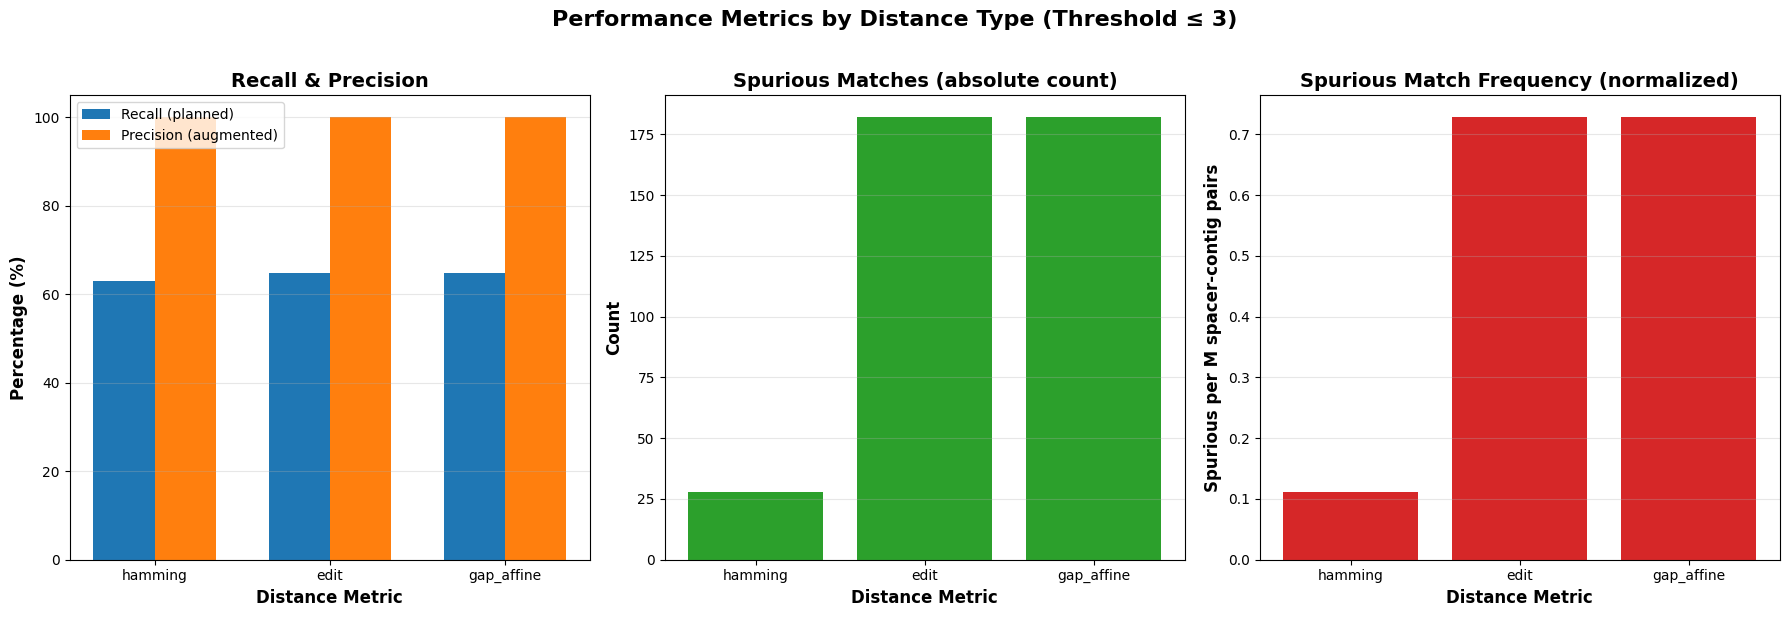

In [8]:
def calculate_metrics_at_threshold(
    results_df: pl.DataFrame,
    distance_column: str,
    threshold: int,
    search_space_info: dict = None,
) -> dict:
    """
    Calculate recall and precision at a specific threshold for a given distance metric.
    
    Args:
        results_df: DataFrame with multi-metric results
        distance_column: Column name for distance metric (e.g., 'distance_hamming')
        threshold: Maximum distance threshold to consider valid
        search_space_info: Optional dict with 'n_spacers', 'n_contigs', 'total_spacer_bp', 'total_contig_bp'
                          for normalized metrics
        
    Returns:
        Dictionary with calculated metrics
    """
    # Filter to alignments within threshold
    valid_alignments = results_df.filter(pl.col(distance_column) <= threshold)
    
    # Count classifications
    total_valid = valid_alignments.height
    positive_in_plan = valid_alignments.filter(pl.col("classification") == "positive_in_plan").height
    positive_not_in_plan = valid_alignments.filter(pl.col("classification") == "positive_not_in_plan").height
    invalid = valid_alignments.filter(pl.col("classification") == "invalid_alignment").height
    
    # Calculate metrics
    # For recall, we need ground truth count
    total_gt = results_df.filter(pl.col("classification") == "positive_in_plan").height
    
    recall_planned = positive_in_plan / total_gt if total_gt > 0 else 0
    precision_planned = positive_in_plan / total_valid if total_valid > 0 else 0
    
    # Augmented metrics (include verified non-planned as TP)
    all_tp = positive_in_plan + positive_not_in_plan
    precision_augmented = all_tp / total_valid if total_valid > 0 else 0
    
    # Invalid rate (true false positive rate)
    invalid_rate_pct = (invalid / total_valid * 100) if total_valid > 0 else 0
    
    result = {
        'metric': distance_column.replace('distance_', ''),
        'threshold': threshold,
        'total_valid_alignments': total_valid,
        'positive_in_plan': positive_in_plan,
        'positive_not_in_plan': positive_not_in_plan,
        'invalid_alignments': invalid,
        'recall_planned': recall_planned,
        'precision_planned': precision_planned,
        'precision_augmented': precision_augmented,
        'invalid_rate_pct': invalid_rate_pct,
    }
    
    # Add normalized metrics if search space info provided
    if search_space_info:
        count_product = search_space_info['n_spacers'] * search_space_info['n_contigs']
        spurious_per_M_pairs = (positive_not_in_plan / count_product) * 1e6
        
        if 'total_spacer_bp' in search_space_info and 'total_contig_bp' in search_space_info:
            search_space_bp2 = search_space_info['total_spacer_bp'] * search_space_info['total_contig_bp']
            spurious_per_Gbp2 = (positive_not_in_plan / search_space_bp2) * 1e9
            result['spurious_per_Gbp2'] = spurious_per_Gbp2
        
        result['spurious_per_M_pairs'] = spurious_per_M_pairs
    
    return result


# Example: Compare metrics at threshold=3
print("METRIC COMPARISON AT THRESHOLD ≤ 3")

# Get search space info for normalization
import pyfastx
spacers_fasta = pyfastx.Fasta(f"{test_sim_dir}/simulated_data/simulated_spacers.fa")
contigs_fasta = pyfastx.Fasta(f"{test_sim_dir}/simulated_data/simulated_contigs.fa")

search_space_info = {
    'n_spacers': len(spacers_fasta),
    'n_contigs': len(contigs_fasta),
    'total_spacer_bp': sum(len(seq) for seq in spacers_fasta),
    'total_contig_bp': sum(len(seq) for seq in contigs_fasta),
}

print(f"Search space: {search_space_info['n_spacers']:,} spacers × {search_space_info['n_contigs']:,} contigs")
print(f"Total: {search_space_info['total_spacer_bp']:,} spacer bp × {search_space_info['total_contig_bp']:,} contig bp\n")

hamming_metrics = calculate_metrics_at_threshold(
    multi_metric_results, 'distance_hamming', 3, search_space_info
)
edit_metrics = calculate_metrics_at_threshold(
    multi_metric_results, 'distance_edit', 3, search_space_info
)
gap_affine_metrics = calculate_metrics_at_threshold(
    multi_metric_results, 'distance_gap_affine', 3, search_space_info
)

comparison_df = pl.DataFrame([hamming_metrics, edit_metrics, gap_affine_metrics])
print(comparison_df.select([
    'metric', 'threshold', 'recall_planned', 'precision_augmented', 
    'positive_not_in_plan', 'spurious_per_M_pairs', 'invalid_rate_pct'
]))

# Create a summary plot - focus on informative metrics
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

metric_names = comparison_df['metric'].to_list()
x = np.arange(len(metric_names))

# Plot 1: Recall and Precision
recall = [r * 100 for r in comparison_df['recall_planned'].to_list()]
precision_aug = [p * 100 for p in comparison_df['precision_augmented'].to_list()]

width = 0.35
ax1.bar(x - width/2, recall, width, label='Recall (planned)', color='#1f77b4')
ax1.bar(x + width/2, precision_aug, width, label='Precision (augmented)', color='#ff7f0e')
ax1.set_xlabel('Distance Metric', fontweight='bold', fontsize=12)
ax1.set_ylabel('Percentage (%)', fontweight='bold', fontsize=12)
ax1.set_title('Recall & Precision', fontweight='bold', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(metric_names)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0, 105])

# Plot 2: Absolute spurious counts
spurious_counts = comparison_df['positive_not_in_plan'].to_list()
ax2.bar(x, spurious_counts, color='#2ca02c')
ax2.set_xlabel('Distance Metric', fontweight='bold', fontsize=12)
ax2.set_ylabel('Count', fontweight='bold', fontsize=12)
ax2.set_title('Spurious Matches (absolute count)', fontweight='bold', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(metric_names)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Spurious frequency (normalized)
spurious_normalized = comparison_df['spurious_per_M_pairs'].to_list()
ax3.bar(x, spurious_normalized, color='#d62728')
ax3.set_xlabel('Distance Metric', fontweight='bold', fontsize=12)
ax3.set_ylabel('Spurious per M spacer-contig pairs', fontweight='bold', fontsize=12)
ax3.set_title('Spurious Match Frequency (normalized)', fontweight='bold', fontsize=14)
ax3.set_xticks(x)
ax3.set_xticklabels(metric_names)
ax3.grid(True, alpha=0.3, axis='y')

plt.suptitle('Performance Metrics by Distance Type (Threshold ≤ 3)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{test_sim_dir}/plots/metrics_comparison_threshold3.png', dpi=150, bbox_inches='tight')
plt.show()

Key observations:
- Recall: Which metric captures more ground truth alignments
- Precision (augmented): Overall accuracy including verified non-planned matches
- Spurious count (absolute): Total spurious matches found (depends on planned insertions)
- Spurious frequency (normalized): Expected spurious matches per search space (independent of planned insertions)


### Batch Processing Multiple Simulations

To analyze all simulations with the multi-metric approach, uncomment and run the cell below. This will:
1. Process each simulation directory
2. Calculate all three distance metrics for all unique alignments
3. Save results to `multi_metric_distances.tsv` in each simulation directory
4. Create a summary comparison across all simulations

**Warning:** This can be time-consuming for large datasets. Start with small simulations first.

In [ ]:
# Create summary comparison across all simulations
summary_data = []

for sim_prefix, results in all_sim_results.items():
    for threshold in [1, 2, 3, 4, 5]:
        for metric_col in ['distance_hamming', 'distance_edit', 'distance_gap_affine']:
            metrics = calculate_metrics_at_threshold(results, metric_col, threshold)
            metrics['simulation'] = sim_prefix
            summary_data.append(metrics)

summary_df = pl.DataFrame(summary_data)

# Save summary
summary_df.write_parquet('results/simulated/multi_metric_summary.parquet')
print("Summary saved to: results/simulated/multi_metric_summary.parquet")
print(summary_df)


---

## Summary: Multi-Metric Distance Analysis

### What This Analysis Provides

This new section calculates **three distance metrics simultaneously** for all unique alignments:

1. **Hamming distance** - substitutions only (traditional CRISPR matching)
2. **Edit distance** - minimal edit distance via edlib (substitutions + indels)
3. **Gap-affine distance** - gap-affine alignment via parasail (configurable gap penalties)

### Key Features

- **Tool-independent**: Analyzes unique alignment regions, not individual tool outputs
- **Region-based indexing**: Groups alignments with fuzzy boundaries (coordinate tolerance)
- **Comprehensive classification**: Matches to ground truth with tolerance, verifies non-matches
- **Flexible filtering**: Pre-calculated distances enable threshold-based subsetting without re-analysis
- **Multi-tool tracking**: Records which tools found each alignment

### Output Schema

Each row represents a unique alignment with:
- **Identifiers**: `alignment_idx`, `region_idx` 
- **Classification**: `positive_in_plan`, `positive_not_in_plan`, `invalid_alignment`
- **Distances**: `distance_hamming`, `distance_edit`, `distance_gap_affine`
- **Metadata**: `tools` (list), `spacer_id`, `contig_id`, `start`, `end`, `strand`
- **Sequences**: `spacer_seq`, `contig_seq` (for validation)
- **Ground Truth**: `planned_mismatches`, `start_gt`, `end_gt` (when available)

### Use Cases

1. **Metric comparison**: How do hamming, edit, and gap-affine distances differ for the same alignments?
2. **Threshold optimization**: What's the optimal threshold for each metric to maximize recall while controlling spurious matches?
3. **Tool agreement**: Which alignments are found by all tools vs. specific tools only?
4. **Spurious match analysis**: How does metric choice affect false discovery rates?

### Example Queries

```python
# Filter to high-confidence matches (all metrics ≤ 2)
high_conf = multi_metric_results.filter(
    (pl.col("distance_hamming") <= 2) &
    (pl.col("distance_edit") <= 2) &
    (pl.col("distance_gap_affine") <= 2)
)

# Find discrepancies where hamming allows but edit rejects
hamming_only = multi_metric_results.filter(
    (pl.col("distance_hamming") <= 3) &
    (pl.col("distance_edit") > 3)
)

# Analyze alignments by region (groups with coordinate tolerance)
by_region = multi_metric_results.group_by("region_idx").agg([
    pl.col("alignment_idx").count().alias("num_alignments"),
    pl.col("tools").flatten().unique().alias("all_tools"),
    pl.col("distance_hamming").min().alias("min_hamming"),
])
```

### Notes

- This analysis complements (does not replace) the existing `compare-results` workflow
- For large datasets, process simulations individually and aggregate results
- The `region_idx` allows grouping alignments with slight coordinate variations
- Invalid alignments (all metrics > threshold) help identify tool reporting issues